In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import math
from scipy.special import kl_div
import torch

In [17]:
def dict_save(dictionary,path):
    with open(path,'wb') as handle:
        pickle.dump(dictionary, handle)
    return 0

def dict_load(path):
    with open(path,'rb') as handle:
        result = pickle.load(handle)
    return result

In [18]:
color_dict = {'nature': 'black',
              'foldingDiff': 'blue',
              'foldingDiff (with O)': 'orange',
              'ours': 'red',
              'ours_guided': 'purple',
              'RFdiffusion': 'green'}

In [19]:
OVERALL_PATH = '../../Results/'
IMAGE_PATH = os.path.join(OVERALL_PATH, 'Images')

In [20]:
PROTEIN_LEN_DICT = dict_load('../../Data/Processed/CATH_forLatentDiff/protein_length.pkl')

In [21]:
def list_summary(val_list, title = None, min_thre = None, max_thre = None, return_val = False):
    if title is not None:
        info = '%s: ' % title
    else:
        info = ''
    
    if not val_list:
        print(info + 'empty!')
        return None
    
    val_list = [val for val in val_list if not np.isnan(val)]
    info += '(%d points) mean=%.6f, median=%.6f, min=%.6f, max=%.6f, std=%.6f' % (
        len(val_list), np.mean(val_list), np.median(val_list), min(val_list), max(val_list), np.std(val_list), 
    )

    ### ratio check
    if min_thre is not None or max_thre is not None:
        count = 0
        for val in val_list:
            if (min_thre is not None and val < min_thre) or (max_thre is not None and val > max_thre):
                continue
            count += 1
        info += ', succ_ratio=%.6f' % (count / len(val_list))
    
    print(info)

    if return_val:
        return np.mean(val_list), np.std(val_list)
    else:
        return None

In [22]:
def rm_bracket(token):
    if '(' in token:
        return token.split('(')[0]
    else:
        return token

In [23]:
def repeat_score(seq, k):
    """ratio of the repeating regions (>=k) in the sequence."""
    if not seq:
        return 0

    char_pre = None
    count = 0
    count_max = 0
    rep_region = 0
    for char in seq + '!':
        if char == char_pre:
            count += 1
        else:
            if count >= k:
                rep_region += count
            count = 1

        char_pre = char
        count_max = max(count_max, count)

    return rep_region / len(seq), count_max / len(seq)

In [24]:
def repeat_load(seq_path, k = 5, threshold = 0.):
    score_list = []
    mr_list = []
    num = 0

    with open(seq_path, 'r') as rf:
        for line in rf:
            if line.startswith('>'):
                continue
            seq = line.strip('\n')
            score, max_repeat = repeat_score(seq, k)
            score_list.append(score)
            mr_list.append(max_repeat)
            if score > threshold:
                num += 1

    return score_list, mr_list, float(num) / len(score_list)

In [25]:
repeat_score(seq = 'fhghhhhhhhweeeeeee', k = 6)

(0.7777777777777778, 0.3888888888888889)

In [26]:
def spectial_token(token):
    if '(' in token and ')' in token:
        return token.split('(')[0] + token.split(')')[-1]
    else:
        return token

def foldability_read(dict_path, plot = False, desired_token = ''):
    result_dict = dict_load(dict_path)
    score_list = []
    len_list = []
    
    for sample in result_dict:
        if desired_token not in sample:
            continue
        score = np.mean(result_dict[sample])
        score_list.append(score)
        
        if sample.startswith('len'):
            l = int(sample.split('len')[-1].split('_')[0])
        else:
            ### nature samples
            len_info = sample.split('_')[-1][1:]
            left_sign = -1 if len_info.startswith('-') else 1
            right_sign = -1 if '--' in len_info else 1
            len_info = [int(spectial_token(token)) for token in len_info.split('-') if token != '']
            l = right_sign * len_info[1] - left_sign * len_info[0] + 1
        len_list.append(l)

    if score_list:
        print('ave_score=%.6f for %d samples.' % (np.mean(score_list), len(score_list)))
        if plot:
            plt.figure(figsize = (4,2))
            plt.xlim(0, 200)
            plt.ylim(0, 0.6)
            plt.scatter(len_list, score_list, color = 'blue', alpha = 0.3)
            plt.xlabel('Protein Size', fontsize = 10)
            plt.ylabel('Foldability (SI)', fontsize = 10)
            plt.show()
    else:
        print('Empty dictionary!')

In [27]:
def consist_summarization_seq(val_dict, token_sele = ''):
    len_list = []
    val_list = []
    
    for sample in val_dict:
        if token_sele not in sample:
            continue
        
        if sample.startswith('len'):
            l = int(sample[3:].split('_')[0])
        elif sample in PROTEIN_LEN_DICT:
            l = PROTEIN_LEN_DICT[sample] 
        else:
            try:
                sample_new = sample[:4] + '_' + sample[5:]
                l_info = sample_new.split('_')[-1][1:]
                left_sign = -1 if l_info.startswith('-') else 1
                right_sign = -1 if '--' in l_info else 1
                l_info = [int(rm_bracket(token)) for token in l_info.split('-') if token != '']
                l = right_sign * l_info[1] - left_sign * l_info[0] + 1
            except:
                l = np.nan
        
        val = np.mean(val_dict[sample])
        len_list.append(l)
        val_list.append(val)

    return val_list, len_list

In [28]:
def consist_summarization_struc(val_dict, token_sele = ''):
    len_list = []
    tmscore_list = []
    rmsd_list = []
    
    for sample in val_dict:
        if token_sele not in sample:
            continue
        
        if sample.startswith('len'):
            l = int(sample[3:].split('_')[0])
        elif sample in PROTEIN_LEN_DICT:
            l = PROTEIN_LEN_DICT[sample] 
        else:
            try:
                sample_new = sample[:4] + '_' + sample[5:]
                l_info = sample_new.split('_')[-1][1:]
                left_sign = -1 if l_info.startswith('-') else 1
                right_sign = -1 if '--' in l_info else 1
                l_info = [int(rm_bracket(token)) for token in l_info.split('-') if token != '']
                l = right_sign * l_info[1] - left_sign * l_info[0] + 1    
            except:
                l = np.nan

        tmscore_temp =[] 
        rmsd_temp = []
        for attempt in val_dict[sample]:
            tmscore_temp.append(val_dict[sample][attempt][0])
            rmsd_temp.append(val_dict[sample][attempt][1])
        tmsore = np.mean(tmscore_temp)
        rmsd = np.mean(rmsd_temp)
        
        len_list.append(l)
        tmscore_list.append(tmsore)
        rmsd_list.append(rmsd)

    return tmscore_list, rmsd_list, len_list

In [29]:
def kind_summary(kind, 
    model_list = None, repeat_thre = 0., print_kind = True, with_latex = False,
    version_list = ['stop', 'last', 'updated']
):
    if print_kind:
        print(kind)
        print('##############################################################')

    if model_list is None:
        model_list = model_dict[kind]
    
    for model in model_list:
        print(model)
        print('**********************************************************')
        for version in version_list:
            latex_info = ''
            
            ### consist-seq
            if kind in consist_seq_dict and model in consist_seq_dict[kind] and version in consist_seq_dict[kind][model]:
                out = list_summary(
                    consist_seq_dict[kind][model][version][0], title = '%s: Consistency-seq'% version, return_val = with_latex
                )
                if with_latex:
                    latex_info += '& %.3f $\pm$ %.2f ' % (out[0], out[1])
            elif with_latex:
                latex_info += '& - '
            
            ### consist-struc
            if kind in consist_struc_dict and model in consist_struc_dict[kind] and version in consist_struc_dict[kind][model]:
                out = list_summary(
                    consist_struc_dict[kind][model][version][0], title = '%s: Consistency-struc-TMscore'% version, return_val = with_latex
                )
                if with_latex:
                    latex_info += '& %.3f $\pm$ %.2f ' % (out[0], out[1])
                list_summary(
                    consist_struc_dict[kind][model][version][1], title = '%s: Consistency-struc-RMSD'% version, max_thre = 2.0
                )
            elif with_latex:
                latex_info += '& - '
                
            ### foldability
            if kind in foldability_dict and model in foldability_dict[kind] and version in foldability_dict[kind][model]:
                out = list_summary(
                    foldability_dict[kind][model][version][0], title = '%s: Foldability'% version, return_val = with_latex
                )
                if with_latex:
                    latex_info += '& %.3f $\pm$ %.2f ' % (out[0], out[1])
            elif with_latex:
                latex_info += '& - '
                    
            ### designability
            if kind in designability_dict and model in designability_dict[kind] and version in designability_dict[kind][model]:
                out = list_summary(
                    designability_dict[kind][model][version][0], title = '%s: Designability-TMscore'% version, return_val = with_latex
                )
                if with_latex:
                    latex_info += '& %.3f $\pm$ %.2f ' % (out[0], out[1])
                list_summary(
                    designability_dict[kind][model][version][1], title = '%s: Designability-RMSD'% version, max_thre = 2.0
                )
            elif with_latex:
                latex_info += '& - '
                
            ### clash
            if kind in feature_dict and model in feature_dict[kind] and version in feature_dict[kind][model]:
                if 'clash' in feature_dict[kind][model][version]:
                    out = list_summary(
                        feature_dict[kind][model][version]['clash'], title = '%s: Clash' % version, return_val = with_latex
                    )
                    if with_latex:
                        latex_info += '& %.3f $\pm$ %.2f ' % (out[0], out[1])
                elif with_latex:
                    latex_info += '& - '
                
                if 'repeat' in feature_dict[kind][model][version]:
                    val_list = feature_dict[kind][model][version]['repeat']
                    ratio = len([val for val in val_list if val > repeat_thre]) / len(val_list) * 100
                    list_summary(val_list, title = '%s: Repeat (%.2f%%)' % (version, ratio))
                if 'max_repeat' in feature_dict[kind][model][version]:
                    list_summary(feature_dict[kind][model][version]['max_repeat'], title = '%s: Max-repeat' % version)
                    
            elif with_latex:
                latex_info += '& - '

            if with_latex:
                print(version, latex_info)
        print()

# Bio-Properties

In [30]:
feature_dict = {}

### Baselines

In [31]:
kind = 'baseline'
feature_dict[kind] = {}

In [32]:
RESULT_PATH = os.path.join(OVERALL_PATH, 'Baselines')
model_list = ['Nature', 'foldingdiff', 'RFdiffusion', 'Chroma', 'protein_generator']

In [33]:
for model in model_list:
    dict_path = os.path.join(RESULT_PATH, model, 'features_summary.pkl')
    seq_path = os.path.join(RESULT_PATH, model, 'seq_gen.fa')
    
    if not (os.path.exists(dict_path) or os.path.exists(seq_path)):
        continue

    print(model)
    if os.path.exists(dict_path):
        if model not in feature_dict[kind]:
            feature_dict[kind][model] = {'stop':{}}
        feature_dict[kind][model]['stop'] = dict_load(dict_path)
        val_list = feature_dict[kind][model]['stop']['clash']
        list_summary(val_list, title = 'Clash')
        
    if os.path.exists(seq_path):
        score_list, mr_list, ratio = repeat_load(seq_path)
        if model not in feature_dict[kind]:
            feature_dict[kind][model] = {'stop':{}}
        feature_dict[kind][model]['stop']['repeat'] = score_list
        feature_dict[kind][model]['stop']['max_repeat'] = mr_list
        list_summary(score_list, title = 'repeating rate (%.2f%%)' % (ratio * 100))
        list_summary(mr_list, title = 'max repeating ratio')
    print('************************************************************')

Nature
Clash: (6017 points) mean=0.046701, median=0.000000, min=0.000000, max=23.000000, std=0.619858
repeating rate (1.29%): (6115 points) mean=0.000676, median=0.000000, min=0.000000, max=0.093750, std=0.006139
max repeating ratio: (6115 points) mean=0.024536, median=0.022222, min=0.010000, max=0.153846, std=0.010856
************************************************************
foldingdiff
Clash: (1810 points) mean=7.860773, median=1.000000, min=0.000000, max=131.000000, std=12.389911
************************************************************
RFdiffusion
Clash: (1792 points) mean=1.222098, median=0.000000, min=0.000000, max=14.000000, std=1.850978
repeating rate (100.00%): (1792 points) mean=1.000000, median=1.000000, min=1.000000, max=1.000000, std=0.000000
max repeating ratio: (1792 points) mean=1.000000, median=1.000000, min=1.000000, max=1.000000, std=0.000000
************************************************************
Chroma
Clash: (1810 points) mean=5.275691, median=4.000000,

### JointDiff

In [34]:
kind = 'JointDiff'
feature_dict[kind] = {}

**Original**

In [35]:
RESULT_PATH = os.path.join(OVERALL_PATH, 'jointDiff')
model_list = [m for m in os.listdir(RESULT_PATH) if m.startswith('codesign')]

In [36]:
for model in model_list:
    dict_path = os.path.join(RESULT_PATH, model, 'features_summary.pkl')
    seq_path = os.path.join(RESULT_PATH, model, 'seq_gen.fa')
    
    if not (os.path.exists(dict_path) or os.path.exists(seq_path)):
        continue

    print(model)
    if os.path.exists(dict_path):
        if model not in feature_dict[kind]:
            feature_dict[kind][model] = {'stop':{}}
        feature_dict[kind][model]['stop'] = dict_load(dict_path)
        val_list = feature_dict[kind][model]['stop']['clash']
        list_summary(val_list, title = 'Clash')
        
    if os.path.exists(seq_path):
        score_list, mr_list, ratio = repeat_load(seq_path)
        if model not in feature_dict[kind]:
            feature_dict[kind][model] = {'stop':{}}
        feature_dict[kind][model]['stop']['repeat'] = score_list
        feature_dict[kind][model]['stop']['max_repeat'] = mr_list
        list_summary(score_list, title = 'repeating rate (%.2f%%)' % (ratio * 100))
        list_summary(mr_list, title = 'max repeating ratio')
    print('************************************************************')

codesign_diffab_complete_gen_share-true_step100_lr1.e-4_wd0.0_posiscale10.0_2024_09_02__20_50_44
repeating rate (1.82%): (5430 points) mean=0.001006, median=0.000000, min=0.000000, max=0.208333, std=0.009650
max repeating ratio: (5430 points) mean=0.031589, median=0.023952, min=0.010000, max=0.208333, std=0.022509
************************************************************
codesign_diffab_complete_gen_share-true_step100_lr1.e-4_wd0.0_posiscaleadapt-20.0_center_2024_09_09__22_25_17
repeating rate (5.58%): (5430 points) mean=0.002906, median=0.000000, min=0.000000, max=0.227273, std=0.014168
max repeating ratio: (5430 points) mean=0.035855, median=0.027211, min=0.010000, max=0.227273, std=0.024789
************************************************************
codesign_diffab_complete_gen_share-true_step100_lr1.e-4_wd0.0_posiscale50.0_sc_center_2024_09_08__22_02_11
repeating rate (0.99%): (5430 points) mean=0.000563, median=0.000000, min=0.000000, max=0.238095, std=0.007916
max repeating r

**UPdated**

In [37]:
RESULT_PATH = os.path.join(OVERALL_PATH, 'jointDiff_updated')
model_list = [m for m in os.listdir(RESULT_PATH) if m.startswith('codesign')]

*Stopping Point*

In [38]:
for model in model_list:
    dict_path = os.path.join(RESULT_PATH, model, 'feat_summary_dict.pkl')
    seq_path = os.path.join(RESULT_PATH, model, 'seq_gen.fa')
    
    if not (os.path.exists(dict_path) or os.path.exists(seq_path)):
        continue

    print(model)
    if os.path.exists(dict_path):
        if model not in feature_dict[kind]:
            feature_dict[kind][model] = {'stop':{}}
        feature_dict[kind][model]['stop'] = dict_load(dict_path)
        val_list = feature_dict[kind][model]['stop']['clash']
        list_summary(val_list, title = 'Clash')
        
    if os.path.exists(seq_path):
        score_list, mr_list, ratio = repeat_load(seq_path)
        if model not in feature_dict[kind]:
            feature_dict[kind][model] = {'stop':{}}
        feature_dict[kind][model]['stop']['repeat'] = score_list
        feature_dict[kind][model]['stop']['max_repeat'] = mr_list
        list_summary(score_list, title = 'repeating rate (%.2f%%)' % (ratio * 100))
        list_summary(mr_list, title = 'max repeating ratio')
    print('************************************************************')

codesign_diffab_complete_gen_share-true_dim-128-64-4_step100_lr1.e-4_wd0._posiscale50.0_sc_center_2024_10_22__22_31_43_loss-0-mse-0-0_uf_mse
Clash: (1810 points) mean=254.160773, median=235.000000, min=34.000000, max=989.000000, std=135.591318
repeating rate (0.72%): (1810 points) mean=0.000361, median=0.000000, min=0.000000, max=0.200000, std=0.005667
max repeating ratio: (1810 points) mean=0.031032, median=0.023529, min=0.010000, max=0.200000, std=0.021247
************************************************************
codesign_diffab_complete_gen_share-true_dim-128-64-4_step100_lr1.e-4_wd0._posiscaleadapt_sc_center_2024_10_21__21_48_21_loss-0-mse-0-0
Clash: (1810 points) mean=19.843646, median=18.000000, min=0.000000, max=153.000000, std=15.536959
repeating rate (7.62%): (1810 points) mean=0.004595, median=0.000000, min=0.000000, max=0.400000, std=0.023127
max repeating ratio: (1810 points) mean=0.039891, median=0.029777, min=0.010000, max=0.400000, std=0.030232
***********************

*Last Points*

In [39]:
for model in model_list:
    dict_path = os.path.join(RESULT_PATH, model, 'feat_summary_dict_last.pkl')
    seq_path = os.path.join(RESULT_PATH, model, 'seq_gen.fa')
    
    if not (os.path.exists(dict_path) or os.path.exists(seq_path)):
        continue

    print(model)
    if os.path.exists(dict_path):
        if model not in feature_dict[kind]:
            feature_dict[kind][model] = {}
        feature_dict[kind][model]['last'] = dict_load(dict_path)
        val_list = feature_dict[kind][model]['last']['clash']
        list_summary(val_list, title = 'Clash')
        
    if os.path.exists(seq_path):
        score_list, mr_list, ratio = repeat_load(seq_path)
        if model not in feature_dict[kind]:
            feature_dict[kind][model] = {}
        if  'last' not in feature_dict[kind][model]:
            feature_dict[kind][model]['last'] = {}
        feature_dict[kind][model]['last']['repeat'] = score_list
        feature_dict[kind][model]['last']['max_repeat'] = mr_list
        list_summary(score_list, title = 'repeating rate (%.2f%%)' % (ratio * 100))
        list_summary(mr_list, title = 'max repeating ratio')
    print('************************************************************')

codesign_diffab_complete_gen_share-true_dim-128-64-4_step100_lr1.e-4_wd0._posiscale50.0_sc_center_2024_10_22__22_31_43_loss-0-mse-0-0_uf_mse
Clash: (1810 points) mean=254.160773, median=235.000000, min=34.000000, max=989.000000, std=135.591318
repeating rate (0.72%): (1810 points) mean=0.000361, median=0.000000, min=0.000000, max=0.200000, std=0.005667
max repeating ratio: (1810 points) mean=0.031032, median=0.023529, min=0.010000, max=0.200000, std=0.021247
************************************************************
codesign_diffab_complete_gen_share-true_dim-128-64-4_step100_lr1.e-4_wd0._posiscaleadapt_sc_center_2024_10_21__21_48_21_loss-0-mse-0-0
Clash: (1810 points) mean=19.843646, median=18.000000, min=0.000000, max=153.000000, std=15.536959
repeating rate (7.62%): (1810 points) mean=0.004595, median=0.000000, min=0.000000, max=0.400000, std=0.023127
max repeating ratio: (1810 points) mean=0.039891, median=0.029777, min=0.010000, max=0.400000, std=0.030232
***********************

In [40]:
RESULT_PATH = os.path.join(OVERALL_PATH, 'jointDiff_updated_eval')
model_list = [m for m in os.listdir(RESULT_PATH) if m.startswith('codesign')]

In [41]:
for model in model_list:
    dict_path = os.path.join(RESULT_PATH, model, 'feat_summary_dict.pkl')
    seq_path = os.path.join(RESULT_PATH, model, 'seq_gen.fa')
    
    if not (os.path.exists(dict_path) or os.path.exists(seq_path)):
        continue

    print(model)
    if os.path.exists(dict_path):
        if model not in feature_dict[kind]:
            feature_dict[kind][model] = {}
        feature_dict[kind][model]['last'] = dict_load(dict_path)
        val_list = feature_dict[kind][model]['last']['clash']
        list_summary(val_list, title = 'Clash')
        
    if os.path.exists(seq_path):
        score_list, mr_list, ratio = repeat_load(seq_path)
        if model not in feature_dict[kind]:
            feature_dict[kind][model] = {}
        if  'updated' not in feature_dict[kind][model]:
            feature_dict[kind][model]['updated'] = {}
        feature_dict[kind][model]['updated']['repeat'] = score_list
        feature_dict[kind][model]['updated']['max_repeat'] = mr_list
        list_summary(score_list, title = 'repeating rate (%.2f%%)' % (ratio * 100))
        list_summary(mr_list, title = 'max repeating ratio')
    print('************************************************************')

codesign_diffab_complete_gen_share-true_dim-128-64-4_step100_lr1.e-4_wd0._posiscaleadapt_sc_center_2024_10_21__21_48_21_loss-0-mse-0-0
Clash: (1810 points) mean=19.843646, median=18.000000, min=0.000000, max=153.000000, std=15.536959
repeating rate (9.23%): (1810 points) mean=0.004972, median=0.000000, min=0.000000, max=0.285714, std=0.021205
max repeating ratio: (1810 points) mean=0.040596, median=0.030849, min=0.010000, max=0.285714, std=0.029542
************************************************************
codesign_diffab_complete_gen_share-true_dim-128-64-4_step100_lr1.e-4_wd0._posiscale50.0_sc_center_2024_10_21__20_52_38_loss-1-mse-1-1_consist-gt-cross
Clash: (1810 points) mean=56.098343, median=48.000000, min=16.000000, max=263.000000, std=29.653603
repeating rate (44.03%): (1810 points) mean=0.030483, median=0.000000, min=0.000000, max=0.500000, std=0.045522
max repeating ratio: (1810 points) mean=0.053289, median=0.041667, min=0.015000, max=0.300000, std=0.034954
***************

### LaDiff

In [42]:
kind = 'LaDiff'
feature_dict[kind] = {}

In [43]:
RESULT_PATH = os.path.join(OVERALL_PATH, 'latentDiff')
model_list = [m for m in os.listdir(RESULT_PATH) if m.startswith('latentdiff')]

In [44]:
for model in model_list:
    dict_path = os.path.join(RESULT_PATH, model, 'feat_summary_dict.pkl')
    seq_path = os.path.join(RESULT_PATH, model, 'samples', 'seq_gen.fa')
    
    if not (os.path.exists(dict_path) or os.path.exists(seq_path)):
        continue

    print(model)
    if os.path.exists(dict_path):
        if model not in feature_dict[kind]:
            feature_dict[kind][model] = {'stop':{}}
        feature_dict[kind][model]['stop'] = dict_load(dict_path)
        val_list = feature_dict[kind][model]['stop']['clash']
        list_summary(val_list, title = 'Clash')
        
    if os.path.exists(seq_path):
        score_list, mr_list, ratio = repeat_load(seq_path)
        if model not in feature_dict[kind]:
            feature_dict[kind][model] = {'stop':{}}
        feature_dict[kind][model]['stop']['repeat'] = score_list
        feature_dict[kind][model]['stop']['max_repeat'] = mr_list
        list_summary(score_list, title = 'repeating rate (%.2f%%)' % (ratio * 100))
        list_summary(mr_list, title = 'max repeating ratio')
    print('************************************************************')

latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_transformer-6_withMask_noise_len-mha_Faster_100steps_micro
Clash: (610 points) mean=3999.140984, median=241.500000, min=0.000000, max=61857.000000, std=9649.487285
repeating rate (56.23%): (610 points) mean=0.142361, median=0.039531, min=0.000000, max=1.000000, std=0.253015
max repeating ratio: (610 points) mean=0.122880, median=0.055472, min=0.010989, max=1.000000, std=0.196971
************************************************************
latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_unet-2-32_withMask_gt_len-linear_Faster_100steps
Clash: (1884 points) mean=7.130573, median=5.000000, min=0.000000, max=46.000000, std=6.351266
repeating rate (26.85%): (1810 points) mean=0.061790, median=0.000000, min=0.000000, max=1.000000, std=0.158042
max repeating ratio: (1810 points) mean=0.076633, median=0.029732, min=0.005263, max=1.000000, std=0.135306
*****************************************************

TypeError: cannot unpack non-iterable int object

**Updated**

In [ ]:
RESULT_PATH = os.path.join(OVERALL_PATH, 'latentDiff_updated')
model_list = [m for m in os.listdir(RESULT_PATH) if m.startswith('latentdiff')]

In [ ]:
for model in model_list:
    dict_path = os.path.join(RESULT_PATH, model, 'feat_summary_dict.pkl')
    seq_path = os.path.join(RESULT_PATH, model, 'samples', 'seq_gen.fa')
    
    if not (os.path.exists(dict_path) or os.path.exists(seq_path)):
        continue

    print(model)
    if os.path.exists(dict_path):
        if model not in feature_dict[kind]:
            feature_dict[kind][model] = {'stop':{}}
        feature_dict[kind][model]['stop'] = dict_load(dict_path)
        val_list = feature_dict[kind][model]['stop']['clash']
        list_summary(val_list, title = 'Clash')
        
    if os.path.exists(seq_path):
        score_list, mr_list, ratio = repeat_load(seq_path)
        if model not in feature_dict[kind]:
            feature_dict[kind][model] = {'stop':{}}
        feature_dict[kind][model]['stop']['repeat'] = score_list
        feature_dict[kind][model]['stop']['max_repeat'] = mr_list
        list_summary(score_list, title = 'repeating rate (%.2f%%)' % (ratio * 100))
        list_summary(mr_list, title = 'max repeating ratio')
    print('************************************************************')

In [ ]:
RESULT_PATH = os.path.join(OVERALL_PATH, 'latentDiff_updated_eval')
model_list = [m for m in os.listdir(RESULT_PATH) if m.startswith('latentdiff')]

In [ ]:
for model in model_list:
    dict_path = os.path.join(RESULT_PATH, model, 'feat_summary_dict.pkl')
    seq_path = os.path.join(RESULT_PATH, model, 'samples', 'seq_gen.fa')
    
    if not (os.path.exists(dict_path) or os.path.exists(seq_path)):
        continue

    print(model)
    if os.path.exists(dict_path):
        if model not in feature_dict[kind]:
            feature_dict[kind][model] = {}
        feature_dict[kind][model]['stop'] = dict_load(dict_path)
        val_list = feature_dict[kind][model]['stop']['clash']
        list_summary(val_list, title = 'Clash')
        
    if os.path.exists(seq_path):
        score_list, mr_list, ratio = repeat_load(seq_path)
        if model not in feature_dict[kind]:
            feature_dict[kind][model] = {'stop':{}}
        feature_dict[kind][model]['stop']['repeat'] = score_list
        feature_dict[kind][model]['stop']['max_repeat'] = mr_list
        list_summary(score_list, title = 'repeating rate (%.2f%%)' % (ratio * 100))
        list_summary(mr_list, title = 'max repeating ratio')
    print('************************************************************')

*Last Point*

In [ ]:
for model in model_list:
    dict_path = os.path.join(RESULT_PATH, model, 'feat_summary_dict_last.pkl')
    seq_path = os.path.join(RESULT_PATH, model, 'samples_last', 'seq_gen.fa')
    
    if not (os.path.exists(dict_path) or os.path.exists(seq_path)):
        continue

    print(model)
    if os.path.exists(dict_path):
        if model not in feature_dict[kind]:
            feature_dict[kind][model] = {}
        feature_dict[kind][model]['last'] = dict_load(dict_path)
        val_list = feature_dict[kind][model]['last']['clash']
        list_summary(val_list, title = 'Clash')
        
    if os.path.exists(seq_path):
        score_list, mr_list, ratio = repeat_load(seq_path)
        if model not in feature_dict[kind]:
            feature_dict[kind][model] = {}
        if  'last' not in feature_dict[kind][model]:
            feature_dict[kind][model]['last'] = {}
        feature_dict[kind][model]['last']['repeat'] = score_list
        feature_dict[kind][model]['last']['max_repeat'] = mr_list
        list_summary(score_list, title = 'repeating rate (%.2f%%)' % (ratio * 100))
        list_summary(mr_list, title = 'max repeating ratio')
    print('************************************************************')
    
    if not os.path.exists(dict_path):
        continue
    d = dict_load(dict_path)
    val_list = d['clash']
    if not val_list:
        continue
    print(model)
    list_summary(val_list, title = 'Clash')
    if model not in feature_dict:
        feature_dict[kind][model] = {}
    feature_dict[kind][model]['last'] = d
    print('************************************************************')

### LaDiff-DiT

In [49]:
kind = 'LaDiff-DiT'
feature_dict[kind] = {}

In [50]:
RESULT_PATH = os.path.join(OVERALL_PATH, 'latentDiff_DiT_warm')
model_list = [m for m in os.listdir(RESULT_PATH) if 'DiT' in m]

In [129]:
for model in model_list:
    print(model)
    
    for token in [
        'ddpm', 'ddim', 'ddpm-uncon-guide', 
        'ddpm_last', 'ddim_last', 'ddpm-uncon-guide_last',
        'ddpm_last-2', 'ddim_last-2', 'ddpm-uncon-guide_last2'
    ]:
        dict_path = os.path.join(RESULT_PATH, model, 'feat_summary_dict_%s.pkl' % token)
        seq_path = os.path.join(RESULT_PATH, model, 'seq_gen_%s.fa' % token)

        if not (os.path.exists(dict_path) or os.path.exists(seq_path)):
            continue
    
        print(token)
        if os.path.exists(dict_path):
            if model not in feature_dict[kind]:
                feature_dict[kind][model] = {}
            if  token not in feature_dict[kind][model]:
                feature_dict[kind][model][token] = {}
            feature_dict[kind][model][token]['clash'] = dict_load(dict_path)['clash']
            val_list = feature_dict[kind][model][token]['clash']
            list_summary(val_list, title = 'Clash')
            
        if os.path.exists(seq_path):
            score_list, mr_list, ratio = repeat_load(seq_path)
            if model not in feature_dict[kind]:
                feature_dict[kind][model] = {}
            if  token not in feature_dict[kind][model]:
                feature_dict[kind][model][token] = {}
            feature_dict[kind][model][token]['repeat'] = score_list
            feature_dict[kind][model][token]['max_repeat'] = mr_list
            list_summary(score_list, title = 'repeating rate (%.2f%%)' % (ratio * 100))
            list_summary(mr_list, title = 'max repeating ratio')
            
    print('************************************************************')
        

# Consistency

## Sequence-centered

In [52]:
consist_seq_dict = {}

### Baselines 

In [53]:
kind = 'baseline'
consist_seq_dict[kind] = {}

In [54]:
RESULT_PATH = os.path.join(OVERALL_PATH, 'Baselines')
model_list = ['Nature', 'Chroma', 'protein_generator']

In [55]:
for model in model_list:
    dict_path = os.path.join(RESULT_PATH, model, 'consistency-seq_dict.pkl')
    if not os.path.exists(dict_path):
        continue
    d = dict_load(dict_path)
    val_list, len_list = consist_summarization_seq(d)
    
    print(model.split('share-true_')[-1])
    list_summary(val_list)
    consist_seq_dict[kind][model] = {'stop': (val_list, len_list)}
    print('************************************************************')

Nature
(6115 points) mean=0.403256, median=0.413131, min=0.017986, max=0.688235, std=0.095175
************************************************************
Chroma
(1810 points) mean=0.326785, median=0.328479, min=0.042532, max=0.603571, std=0.084767
************************************************************
protein_generator
(1810 points) mean=0.327110, median=0.344610, min=0.010870, max=0.543519, std=0.086190
************************************************************


### JointDiff

In [56]:
kind = 'JointDiff'
consist_seq_dict[kind] = {}

**Previous**

In [57]:
RESULT_PATH = os.path.join(OVERALL_PATH, 'jointDiff')
model_list = [m for m in os.listdir(RESULT_PATH) if m.startswith('codesign')]

In [58]:
for model in model_list:
    dict_path = os.path.join(RESULT_PATH, model, 'foldability_dict.pkl')
    if not os.path.exists(dict_path):
        continue
    d = dict_load(dict_path)
    val_list, len_list = consist_summarization_seq(d)
    
    print(model.split('share-true_')[-1])
    list_summary(val_list)
    consist_seq_dict[kind][model] = {'stop': (val_list, len_list)}
    print('************************************************************')

step100_lr1.e-4_wd0.0_posiscale10.0_2024_09_02__20_50_44
(1810 points) mean=0.205717, median=0.208122, min=0.011111, max=0.340911, std=0.033928
************************************************************
step100_lr1.e-4_wd0.0_posiscaleadapt_2024_09_02__19_14_48
(1810 points) mean=0.182826, median=0.187261, min=0.031867, max=0.334783, std=0.040450
************************************************************
step100_lr1.e-4_wd0.0_posiscaleadapt_2024_09_02__20_24_39
(1810 points) mean=0.190738, median=0.195662, min=0.005000, max=0.382857, std=0.038719
************************************************************
step100_lr1.e-4_wd0.0_posiscale1.0_2024_09_02__20_50_44
(1810 points) mean=0.259363, median=0.261993, min=0.095254, max=0.480952, std=0.051750
************************************************************
dim-256_step100_lr1.e-4_wd0.0_posiscale100.0_sc_center_2024_09_10__13_06_07
(1329 points) mean=0.077831, median=0.075910, min=0.000000, max=0.213907, std=0.034098
****************

**Updated**

In [59]:
RESULT_PATH = os.path.join(OVERALL_PATH, 'jointDiff_updated')
model_list = [m for m in os.listdir(RESULT_PATH) if m.startswith('codesign')]

*Coverged point*

In [60]:
for model in model_list:
    dict_path = os.path.join(RESULT_PATH, model, 'consistency-seq_dict.pkl')
    if not os.path.exists(dict_path):
        continue
    d = dict_load(dict_path)
    val_list, len_list = consist_summarization_seq(d)
    
    print(model.split('share-true_')[-1])
    list_summary(val_list)
    consist_seq_dict[kind][model] = {'stop': (val_list, len_list)}
    print('************************************************************')

dim-128-64-4_step100_lr1.e-4_wd0._posiscale50.0_sc_center_2024_10_22__22_31_43_loss-0-mse-0-0_uf_mse
(1810 points) mean=0.126596, median=0.130232, min=0.019231, max=0.230997, std=0.035908
************************************************************
dim-128-64-4_step100_lr1.e-4_wd0._posiscaleadapt_sc_center_2024_10_21__21_48_21_loss-0-mse-0-0
(1810 points) mean=0.220787, median=0.225237, min=0.053216, max=0.350000, std=0.035395
************************************************************
dim-128-64-4_step100_lr1.e-4_wd0._posiscale50.0_sc_center_2024_10_22__07_29_49_loss-1-mse-0-0_grace
(1810 points) mean=0.011313, median=0.002564, min=0.000000, max=0.140000, std=0.018634
************************************************************
dim-128-64-4_step100_lr1.e-4_wd0._posiscale50.0_sc_center_2024_10_21__20_52_38_loss-1-mse-1-1_consist-gt-cross
(1810 points) mean=0.243784, median=0.246930, min=0.028571, max=0.484615, std=0.065821
************************************************************
d

*Last point*

In [61]:
for model in model_list:
    dict_path = os.path.join(RESULT_PATH, model, 'consistency-seq_last_dict.pkl')
    if not os.path.exists(dict_path):
        continue
    d = dict_load(dict_path)
    val_list, len_list = consist_summarization_seq(d)
    
    print(model.split('share-true_')[-1])
    list_summary(val_list)
    if model not in consist_seq_dict[kind]:
        consist_seq_dict[kind][model] = {}
    consist_seq_dict[kind][model]['last'] = (val_list, len_list)
    print('************************************************************')

dim-128-64-4_step100_lr1.e-4_wd0._posiscale50.0_sc_center_2024_10_22__22_31_43_loss-0-mse-0-0_uf_mse
(1810 points) mean=0.129002, median=0.131717, min=0.004762, max=0.238821, std=0.040271
************************************************************
dim-128-64-4_step100_lr1.e-4_wd0._posiscaleadapt_sc_center_2024_10_21__21_48_21_loss-0-mse-0-0
(1810 points) mean=0.230393, median=0.234390, min=0.062394, max=0.384615, std=0.036839
************************************************************
dim-128-64-4_step100_lr1.e-4_wd0._posiscale50.0_sc_center_2024_10_22__07_29_49_loss-1-mse-0-0_grace
(1810 points) mean=0.015322, median=0.002494, min=0.000000, max=0.290000, std=0.026799
************************************************************
dim-128-64-4_step100_lr1.e-4_wd0._posiscale50.0_sc_center_2024_10_21__20_52_38_loss-1-mse-1-1_consist-gt-cross
(1810 points) mean=0.257539, median=0.252291, min=0.005000, max=0.511117, std=0.062167
************************************************************
d

In [62]:
RESULT_PATH = os.path.join(OVERALL_PATH, 'jointDiff_updated_eval')
model_list = [m for m in os.listdir(RESULT_PATH) if m.startswith('codesign')]

In [63]:
for model in model_list:
    dict_path = os.path.join(RESULT_PATH, model, 'consistency-seq_dict.pkl')
    if not os.path.exists(dict_path):
        continue
    d = dict_load(dict_path)
    val_list, len_list = consist_summarization_seq(d)
    
    print(model.split('share-true_')[-1])
    list_summary(val_list)
    if model not in consist_seq_dict[kind]:
        consist_seq_dict[kind][model] = {}
    consist_seq_dict[kind][model]['updated'] = (val_list, len_list)
    print('************************************************************')

dim-128-64-4_step100_lr1.e-4_wd0._posiscaleadapt_sc_center_2024_10_21__21_48_21_loss-0-mse-0-0
(1810 points) mean=0.230393, median=0.234390, min=0.062394, max=0.384615, std=0.036839
************************************************************
dim-128-64-4_step100_lr1.e-4_wd0._posiscale50.0_sc_center_2024_10_21__20_52_38_loss-1-mse-1-1_consist-gt-cross
(1810 points) mean=0.257540, median=0.252291, min=0.005000, max=0.511117, std=0.062166
************************************************************
dim-256-128-2_step100_lr1.e-4_wd0._posiscale50.0_sc_center_2024_10_24__20_48_33_loss-1-mse-1-1_rm_mse
(1810 points) mean=0.181733, median=0.184292, min=0.034211, max=0.315840, std=0.041140
************************************************************
dim-128-64-4_step100_lr1.e-4_wd0._posiscale50.0_sc_center_2024_10_20__23_57_14_loss-1-mse-1-1
(1810 points) mean=0.013413, median=0.002510, min=0.000000, max=0.242857, std=0.025554
************************************************************
dim-12

### LaDiff

In [64]:
kind = 'LaDiff'
consist_seq_dict[kind] = {}

In [65]:
RESULT_PATH = os.path.join(OVERALL_PATH, 'latentDiff')
model_list = [m for m in os.listdir(RESULT_PATH) if m.startswith('latent')]

In [66]:
for model in model_list:
    dict_path = os.path.join(RESULT_PATH, model, 'foldability_dict.pkl')
    if not os.path.exists(dict_path):
        continue
    d = dict_load(dict_path)
    val_list, len_list = consist_summarization_seq(d)
    
    print(model.split('share-true_')[-1])
    list_summary(val_list)
    consist_seq_dict[kind][model] = {'stop': (val_list, len_list)}
    print('************************************************************')

latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_unet-2-32_withMask_gt_len-linear_Faster_100steps
(740 points) mean=0.164116, median=0.167549, min=0.000000, max=0.367672, std=0.057255
************************************************************
latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_unet-2-64_withMask_gt_Faster_100steps
(740 points) mean=0.169020, median=0.153318, min=0.000000, max=0.679018, std=0.087971
************************************************************
latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_unet-2-64_withMask_gt_len-linear_Faster_100steps
(740 points) mean=0.152309, median=0.153659, min=0.000000, max=0.430833, std=0.053016
************************************************************
latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_unet-2-32_withMask_gt_Faster_100steps
(740 points) mean=0.148838, median=0.152682, min=0.000000, max=0.330952, std=0.055438
*******************

**Updated**

In [67]:
RESULT_PATH = os.path.join(OVERALL_PATH, 'latentDiff_updated')
model_list = [m for m in os.listdir(RESULT_PATH) if m.startswith('latent')]

FileNotFoundError: [Errno 2] No such file or directory: '../../Results/latentDiff_updated'

In [ ]:
for model in model_list:
    dict_path = os.path.join(RESULT_PATH, model, 'consistency-seq_dict.pkl')
    if not os.path.exists(dict_path):
        continue
    d = dict_load(dict_path)
    val_list, len_list = consist_summarization_seq(d)
    
    print(model.split('share-true_')[-1])
    list_summary(val_list)
    consist_seq_dict[kind][model] = {'stop': (val_list, len_list)}
    print('************************************************************')

In [ ]:
RESULT_PATH = os.path.join(OVERALL_PATH, 'latentDiff_updated_eval')
model_list = [m for m in os.listdir(RESULT_PATH) if m.startswith('latent')]

In [ ]:
for model in model_list:
    dict_path = os.path.join(RESULT_PATH, model, 'consistency-seq_dict.pkl')
    if not os.path.exists(dict_path):
        continue
    d = dict_load(dict_path)
    val_list, len_list = consist_summarization_seq(d)
    
    print(model.split('share-true_')[-1])
    list_summary(val_list)
    consist_seq_dict[kind][model] = {'stop': (val_list, len_list)}
    print('************************************************************')

*last point*

In [ ]:
for model in model_list:
    dict_path = os.path.join(RESULT_PATH, model, 'consistency-seq_last_dict.pkl')
    if not os.path.exists(dict_path):
        continue
    d = dict_load(dict_path)
    val_list, len_list = consist_summarization_seq(d)
    
    print(model.split('share-true_')[-1])
    list_summary(val_list)
    if model not in consist_seq_dict[kind]:
        consist_seq_dict[kind][model] = {}
    consist_seq_dict[kind][model]['last'] = (val_list, len_list)
    print('************************************************************')


### LaDiff-DiT

In [130]:
kind = 'LaDiff-DiT'
consist_seq_dict[kind] = {}

RESULT_PATH = os.path.join(OVERALL_PATH, 'latentDiff_DiT_warm')
model_list = [m for m in os.listdir(RESULT_PATH) if 'DiT' in m]

for model in model_list:
    print(model)
    
    for token in [
        'ddpm', 'ddim', 'ddpm-uncon-guide', 
        'ddpm_last', 'ddim_last', 'ddpm-uncon-guide_last',
        'ddpm_last-2', 'ddim_last-2', 'ddpm-uncon-guide_last2'
    ]:
        dict_path = os.path.join(RESULT_PATH, model, 'consistency-seq_%s_dict.pkl' % token)
        if not os.path.exists(dict_path):
            continue
        d = dict_load(dict_path)
        val_list, len_list = consist_summarization_seq(d)
        
        list_summary(val_list, title=token)
        if model not in consist_seq_dict[kind]:
            consist_seq_dict[kind][model] = {}
        consist_seq_dict[kind][model][token] = (val_list, len_list)
    print('************************************************************')
        

005-DiT-M-withLen-withMask_diff-linear-500_warm_withLenClus_bin10_upsampling_warm
ddpm-uncon-guide_last: (488 points) mean=0.223824, median=0.198860, min=0.013043, max=0.595732, std=0.102551
ddpm-uncon-guide_last2: (488 points) mean=0.233430, median=0.203351, min=0.017391, max=0.605607, std=0.111486
************************************************************
004-DiT-M-withLen-withMask_diff-linear-500_warm_withLenClus_bin5_upsampling_warm
ddpm-uncon-guide_last: (488 points) mean=0.222965, median=0.198342, min=0.008696, max=0.583178, std=0.096358
ddpm-uncon-guide_last2: (488 points) mean=0.224233, median=0.197377, min=0.004348, max=0.600935, std=0.102447
************************************************************
000-DiT-M-withLen-withMask_diff-linear-500_warm_withLenClus_bin5_warm_updated
ddpm-uncon-guide_last: (488 points) mean=0.221732, median=0.201047, min=0.004348, max=0.575701, std=0.096583
ddpm-uncon-guide_last2: (488 points) mean=0.213228, median=0.192254, min=0.017391, max=0.6

## Structure-centered

In [69]:
consist_struc_dict = {}

### Baselines

In [70]:
kind = 'baseline'
consist_struc_dict[kind] = {}

In [71]:
RESULT_PATH = os.path.join(OVERALL_PATH, 'Baselines')
model_list = ['Nature', 'Chroma', 'protein_generator']

In [72]:
for model in model_list:
    dict_path = os.path.join(RESULT_PATH, model, 'consistency-struc_dict.pkl')
    if not os.path.exists(dict_path):
        continue
    d = dict_load(dict_path)
    tmscore_list, rmsd_list, len_list = consist_summarization_struc(d)
    
    print(model.split('share-true_')[-1])
    list_summary(tmscore_list, title = 'TM-score')
    list_summary(rmsd_list, title = 'RMSD', max_thre = 2.0)
    consist_struc_dict[kind][model] = {'stop': (tmscore_list, rmsd_list, len_list)}
    print('************************************************************')

Nature
TM-score: (1956 points) mean=0.868502, median=0.928605, min=0.155550, max=0.996540, std=0.159735
RMSD: (1956 points) mean=1.449632, median=1.260000, min=0.190000, max=6.210000, std=0.860024, succ_ratio=0.807260
************************************************************
Chroma
TM-score: (1810 points) mean=0.768605, median=0.822895, min=0.160390, max=0.973610, std=0.162344
RMSD: (1810 points) mean=2.015746, median=1.840000, min=0.220000, max=5.490000, std=0.944329, succ_ratio=0.575138
************************************************************
protein_generator
TM-score: (1810 points) mean=0.737970, median=0.763145, min=0.304710, max=0.979010, std=0.141760
RMSD: (1810 points) mean=2.217901, median=2.170000, min=0.210000, max=5.310000, std=1.038142, succ_ratio=0.434807
************************************************************


### JointDiff

In [73]:
kind = 'JointDiff'
consist_struc_dict[kind] = {}

**Original**

In [74]:
RESULT_PATH = os.path.join(OVERALL_PATH, 'jointDiff')
model_list = [m for m in os.listdir(RESULT_PATH) if m.startswith('codesign')]

In [75]:
for model in model_list:
    dict_path = os.path.join(RESULT_PATH, model, 'joint-consistency_esmfold_TMscore_dict.pkl')
    if not os.path.exists(dict_path):
        continue
    d = dict_load(dict_path)
    tmscore_list, rmsd_list, len_list  = consist_summarization_struc(d, token_sele = '_0_')
    
    print(model.split('share-true_')[-1])
    list_summary(tmscore_list, title = 'TM-score')
    list_summary(rmsd_list, title = 'RMSD', max_thre = 2.0)
    consist_struc_dict[kind][model] = {'stop': (tmscore_list, rmsd_list, len_list)}
    print('************************************************************')

step100_lr1.e-4_wd0.0_posiscale10.0_2024_09_02__20_50_44
TM-score: (1810 points) mean=0.428072, median=0.407195, min=0.125020, max=0.848720, std=0.101343
RMSD: (1810 points) mean=3.542530, median=3.780000, min=0.520000, max=6.170000, std=1.250838, succ_ratio=0.141989
************************************************************
step100_lr1.e-4_wd0.0_posiscaleadapt-20.0_center_2024_09_09__22_25_17
TM-score: (1810 points) mean=0.524867, median=0.509875, min=0.131490, max=0.865080, std=0.128951
RMSD: (1810 points) mean=3.009580, median=3.085000, min=0.650000, max=6.100000, std=1.176901, succ_ratio=0.246409
************************************************************
step100_lr1.e-4_wd0.0_posiscale50.0_sc_center_2024_09_08__22_02_11
TM-score: (1810 points) mean=0.351795, median=0.336045, min=0.099900, max=0.734590, std=0.109718
RMSD: (1810 points) mean=3.595387, median=3.765000, min=0.850000, max=6.380000, std=1.268283, succ_ratio=0.151381
***************************************************

**Updated**

In [76]:
RESULT_PATH = os.path.join(OVERALL_PATH, 'jointDiff_updated')
model_list = [m for m in os.listdir(RESULT_PATH) if m.startswith('codesign')]

*Stopping Point*

In [77]:
for model in model_list:
    dict_path = os.path.join(RESULT_PATH, model, 'consistency-struc_dict.pkl')
    if not os.path.exists(dict_path):
        continue
    d = dict_load(dict_path)
    tmscore_list, rmsd_list, len_list = consist_summarization_struc(d)
    
    print(model.split('share-true_')[-1])
    list_summary(tmscore_list, title = 'TM-score')
    list_summary(rmsd_list, title = 'RMSD', max_thre = 2.0)
    consist_struc_dict[kind][model] = {'stop': (tmscore_list, rmsd_list, len_list)}
    print('************************************************************')

dim-128-64-4_step100_lr1.e-4_wd0._posiscale50.0_sc_center_2024_10_22__22_31_43_loss-0-mse-0-0_uf_mse
TM-score: (1810 points) mean=0.324100, median=0.317290, min=0.092410, max=0.660720, std=0.082570
RMSD: (1810 points) mean=3.750865, median=3.905000, min=1.120000, max=6.700000, std=1.179165, succ_ratio=0.103315
************************************************************
dim-128-64-4_step100_lr1.e-4_wd0._posiscaleadapt_sc_center_2024_10_21__21_48_21_loss-0-mse-0-0
TM-score: (1810 points) mean=0.357955, median=0.352670, min=0.083450, max=0.653860, std=0.069402
RMSD: (1810 points) mean=3.689812, median=3.930000, min=0.360000, max=6.320000, std=1.249347, succ_ratio=0.138122
************************************************************
dim-128-64-4_step100_lr1.e-4_wd0._posiscale50.0_sc_center_2024_10_22__07_29_49_loss-1-mse-0-0_grace
TM-score: (1810 points) mean=0.238811, median=0.235270, min=0.096150, max=0.409560, std=0.041054
RMSD: (1810 points) mean=4.655746, median=4.790000, min=1.36000

*Last Point*

In [78]:
for model in model_list:
    dict_path = os.path.join(RESULT_PATH, model, 'consistency-struc_last_dict.pkl')
    if not os.path.exists(dict_path):
        continue
    d = dict_load(dict_path)
    tmscore_list, rmsd_list, len_list = consist_summarization_struc(d)
    
    print(model.split('share-true_')[-1])
    list_summary(tmscore_list, title = 'TM-score')
    list_summary(rmsd_list, title = 'RMSD', max_thre = 2.0)
    if model not in consist_struc_dict[kind]:
        consist_struc_dict[kind][model] = {}
    consist_struc_dict[kind][model]['last'] = (tmscore_list, rmsd_list, len_list)
    print('************************************************************')

dim-128-64-4_step100_lr1.e-4_wd0._posiscale50.0_sc_center_2024_10_22__22_31_43_loss-0-mse-0-0_uf_mse
TM-score: (1810 points) mean=0.344032, median=0.330215, min=0.096090, max=0.721470, std=0.102661
RMSD: (1810 points) mean=3.581624, median=3.735000, min=0.940000, max=6.520000, std=1.223113, succ_ratio=0.143094
************************************************************
dim-128-64-4_step100_lr1.e-4_wd0._posiscaleadapt_sc_center_2024_10_21__21_48_21_loss-0-mse-0-0
TM-score: (1810 points) mean=0.368200, median=0.363795, min=0.109700, max=0.656130, std=0.063896
RMSD: (1810 points) mean=3.614188, median=3.810000, min=0.500000, max=6.480000, std=1.229249, succ_ratio=0.137017
************************************************************
dim-128-64-4_step100_lr1.e-4_wd0._posiscale50.0_sc_center_2024_10_22__07_29_49_loss-1-mse-0-0_grace
TM-score: (1810 points) mean=0.255636, median=0.252655, min=0.099350, max=0.421710, std=0.043863
RMSD: (1810 points) mean=4.611721, median=4.700000, min=1.34000

In [79]:
RESULT_PATH = os.path.join(OVERALL_PATH, 'jointDiff_updated_eval')
model_list = [m for m in os.listdir(RESULT_PATH) if m.startswith('codesign')]

In [80]:
for model in model_list:
    dict_path = os.path.join(RESULT_PATH, model, 'consistency-struc_dict.pkl')
    if not os.path.exists(dict_path):
        continue
    d = dict_load(dict_path)
    tmscore_list, rmsd_list, len_list = consist_summarization_struc(d)
    
    print(model.split('share-true_')[-1])
    list_summary(tmscore_list, title = 'TM-score')
    list_summary(rmsd_list, title = 'RMSD', max_thre = 2.0)
    if model not in consist_struc_dict[kind]:
        consist_struc_dict[kind][model] = {}
    consist_struc_dict[kind][model]['updated'] = (tmscore_list, rmsd_list, len_list)
    print('************************************************************')

dim-128-64-4_step100_lr1.e-4_wd0._posiscaleadapt_sc_center_2024_10_21__21_48_21_loss-0-mse-0-0
TM-score: (1810 points) mean=0.368035, median=0.364035, min=0.111250, max=0.656170, std=0.063749
RMSD: (1810 points) mean=3.615536, median=3.820000, min=0.490000, max=6.280000, std=1.228249, succ_ratio=0.139227
************************************************************
dim-128-64-4_step100_lr1.e-4_wd0._posiscale50.0_sc_center_2024_10_21__20_52_38_loss-1-mse-1-1_consist-gt-cross
TM-score: (1810 points) mean=0.463234, median=0.442235, min=0.097190, max=0.836260, std=0.122999
RMSD: (1810 points) mean=3.109000, median=3.195000, min=0.340000, max=5.880000, std=1.128441, succ_ratio=0.177901
************************************************************
dim-256-128-2_step100_lr1.e-4_wd0._posiscale50.0_sc_center_2024_10_24__20_48_33_loss-1-mse-1-1_rm_mse
TM-score: (1810 points) mean=0.529264, median=0.504800, min=0.194240, max=0.927600, std=0.124675
RMSD: (1810 points) mean=2.972348, median=3.135000,

### LaDiff

In [ ]:
kind = 'LaDiff'
consist_struc_dict[kind] = {}

**Origin**

In [ ]:
RESULT_PATH = os.path.join(OVERALL_PATH, 'latentDiff')
model_list = [m for m in os.listdir(RESULT_PATH) if m.startswith('latent')]

In [ ]:
for model in model_list:
    dict_path = os.path.join(RESULT_PATH, model, 'joint-consistency_esmfold_TMscore_dict.pkl')
    if not os.path.exists(dict_path):
        continue
    d = dict_load(dict_path)
    tmscore_list, rmsd_list, len_list = consist_summarization_struc(d)
    
    print(model.split('share-true_')[-1])
    list_summary(tmscore_list, title = 'TM-score')
    list_summary(rmsd_list, title = 'RMSD', max_thre = 2.0)
    if model not in consist_struc_dict[kind]:
        consist_struc_dict[kind][model] = {}
    consist_struc_dict[kind][model]['stop'] = (tmscore_list, rmsd_list, len_list)
    print('************************************************************')

**Updated**

In [ ]:
RESULT_PATH = os.path.join(OVERALL_PATH, 'latentDiff_updated/')
model_list = [m for m in os.listdir(RESULT_PATH) if m.startswith('latent')]

In [ ]:
for model in model_list:
    dict_path = os.path.join(RESULT_PATH, model, 'consistency-struc_dict.pkl')
    if not os.path.exists(dict_path):
        continue
    d = dict_load(dict_path)
    tmscore_list, rmsd_list, len_list = consist_summarization_struc(d)
    
    print(model.split('share-true_')[-1])
    list_summary(tmscore_list, title = 'TM-score')
    list_summary(rmsd_list, title = 'RMSD', max_thre = 2.0)
    if model not in consist_struc_dict[kind]:
        consist_struc_dict[kind][model] = {}
    consist_struc_dict[kind][model]['stop'] = (tmscore_list, rmsd_list, len_list)
    print('************************************************************')

In [ ]:
RESULT_PATH = os.path.join(OVERALL_PATH, 'latentDiff_updated_eval/')
model_list = [m for m in os.listdir(RESULT_PATH) if m.startswith('latent')]

In [ ]:
for model in model_list:
    dict_path = os.path.join(RESULT_PATH, model, 'consistency-struc_dict.pkl')
    if not os.path.exists(dict_path):
        continue
    d = dict_load(dict_path)
    tmscore_list, rmsd_list, len_list = consist_summarization_struc(d)
    
    print(model.split('share-true_')[-1])
    list_summary(tmscore_list, title = 'TM-score')
    list_summary(rmsd_list, title = 'RMSD', max_thre = 2.0)
    if model not in consist_struc_dict[kind]:
        consist_struc_dict[kind][model] = {}
    consist_struc_dict[kind][model]['stop'] = (tmscore_list, rmsd_list, len_list)
    print('************************************************************')

*Last point*

In [ ]:
for model in model_list:
    dict_path = os.path.join(RESULT_PATH, model, 'consistency-struc_last_dict.pkl')
    if not os.path.exists(dict_path):
        continue
    d = dict_load(dict_path)
    tmscore_list, rmsd_list, len_list = consist_summarization_struc(d)
    
    print(model.split('share-true_')[-1])
    list_summary(tmscore_list, title = 'TM-score')
    list_summary(rmsd_list, title = 'RMSD', max_thre = 2.0)
    if model not in consist_struc_dict[kind]:
        consist_struc_dict[kind][model] = {}
    consist_struc_dict[kind][model]['last'] = (tmscore_list, rmsd_list, len_list)
    print('************************************************************')

### LaDiff-DiT

In [131]:
kind = 'LaDiff-DiT'
consist_struc_dict[kind] = {}

RESULT_PATH = os.path.join(OVERALL_PATH, 'latentDiff_DiT_warm')
model_list = [m for m in os.listdir(RESULT_PATH) if 'DiT' in m]

for model in model_list:
    print(model)
    
    for token in [
        'ddpm', 'ddim', 'ddpm-uncon-guide', 
        'ddpm_last', 'ddim_last', 'ddpm-uncon-guide_last',
        'ddpm_last-2', 'ddim_last-2', 'ddpm-uncon-guide_last2'
    ]:
        dict_path = os.path.join(RESULT_PATH, model, 'consistency-struc_%s_dict.pkl' % token)
        if not os.path.exists(dict_path):
            continue
        d = dict_load(dict_path)
        tmscore_list, rmsd_list, len_list = consist_summarization_struc(d)
        
        list_summary(tmscore_list, title = '(%s) TM-score' % token)
        list_summary(rmsd_list, title = '(%s) RMSD' % token, max_thre = 2.0)
        if model not in consist_struc_dict[kind]:
            consist_struc_dict[kind][model] = {}
        consist_struc_dict[kind][model][token] = (tmscore_list, rmsd_list, len_list)
    print('************************************************************')

005-DiT-M-withLen-withMask_diff-linear-500_warm_withLenClus_bin10_upsampling_warm
(ddpm-uncon-guide_last) TM-score: (488 points) mean=0.487642, median=0.380535, min=0.181380, max=0.997480, std=0.242221
(ddpm-uncon-guide_last) RMSD: (488 points) mean=3.379139, median=3.690000, min=0.070000, max=6.200000, std=1.640354, succ_ratio=0.223361
(ddpm-uncon-guide_last2) TM-score: (488 points) mean=0.515656, median=0.385295, min=0.193770, max=0.994980, std=0.254268
(ddpm-uncon-guide_last2) RMSD: (488 points) mean=3.273924, median=3.705000, min=0.080000, max=6.560000, std=1.729053, succ_ratio=0.301230
************************************************************
004-DiT-M-withLen-withMask_diff-linear-500_warm_withLenClus_bin5_upsampling_warm
(ddpm-uncon-guide_last) TM-score: (488 points) mean=0.470016, median=0.357580, min=0.209760, max=0.994670, std=0.230107
(ddpm-uncon-guide_last) RMSD: (488 points) mean=3.518832, median=3.810000, min=0.130000, max=6.400000, std=1.616683, succ_ratio=0.217213
(dd

# Sample Quality

## Foldability (sequence)

In [82]:
foldability_dict = {}

### Baselines 

In [83]:
kind = 'baseline'
foldability_dict[kind] = {}

In [84]:
RESULT_PATH = os.path.join(OVERALL_PATH, 'Baselines')
model_list = ['Nature', 'foldingdiff', 'RFdiffusion', 'Chroma', 'protein_generator']

In [85]:
for model in model_list:
    dict_path = os.path.join(RESULT_PATH, model, 'seq_foldability.pkl')
    if not os.path.exists(dict_path):
        continue
    d = dict_load(dict_path)
    val_list, len_list = consist_summarization_seq(d)
    
    print(model)
    list_summary(val_list, title = 'Foldability')
    foldability_dict[kind][model] = {'stop': (val_list, len_list)}
    print('************************************************************')

Nature
Foldability: (1956 points) mean=0.435631, median=0.447473, min=0.033333, max=0.688496, std=0.107382
************************************************************
Chroma
Foldability: (1810 points) mean=0.419101, median=0.431782, min=0.056345, max=0.672222, std=0.094865
************************************************************
protein_generator
Foldability: (1810 points) mean=0.384680, median=0.416394, min=0.001923, max=0.701053, std=0.117884
************************************************************


Nature
ave_score=0.435631 for 1956 samples.


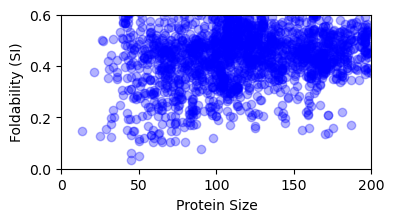

###################################################
Chroma
ave_score=0.419101 for 1810 samples.


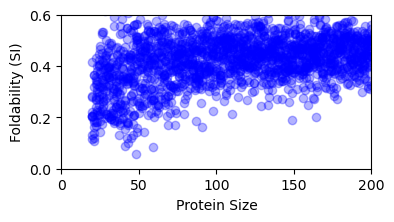

###################################################
protein_generator
ave_score=0.384680 for 1810 samples.


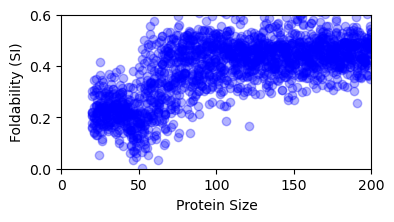

###################################################


In [86]:
with_plot = True

for model in ['Nature', 'Chroma', 'protein_generator']:
    print(model)
    dict_path = os.path.join(RESULT_PATH, model, 'seq_foldability.pkl')
    try:
        foldability_read(dict_path, plot = with_plot)
    except Exception as e:
        print(e)
    print('###################################################')

### JointDiff

In [87]:
kind = 'JointDiff'
foldability_dict[kind] = {}

In [88]:
RESULT_PATH = '../../Results/jointDiff/'
model_list = [m for m in os.listdir(RESULT_PATH) if m.startswith('codesign_diffab_complete_gen_share-true')]

In [89]:
for model in model_list:
    dict_path = os.path.join(RESULT_PATH, model, 'seq-foldability.pkl')
    if not os.path.exists(dict_path):
        continue
    d = dict_load(dict_path)
    val_list, len_list = consist_summarization_seq(d)
    
    print(model.split('share-true_')[-1])
    list_summary(val_list, title = 'Foldability')
    foldability_dict[kind][model] = {'stop': (val_list, len_list)}
    print('************************************************************')

step100_lr1.e-4_wd0.0_posiscale10.0_2024_09_02__20_50_44
Foldability: (1810 points) mean=0.231976, median=0.237092, min=0.053846, max=0.393993, std=0.048342
************************************************************
step100_lr1.e-4_wd0.0_posiscaleadapt-20.0_center_2024_09_09__22_25_17
Foldability: (5430 points) mean=0.219915, median=0.225917, min=0.042857, max=0.397915, std=0.051674
************************************************************
step100_lr1.e-4_wd0.0_posiscale50.0_sc_center_2024_09_08__22_02_11
Foldability: (5430 points) mean=0.168958, median=0.172039, min=0.000000, max=0.365000, std=0.043160
************************************************************
dim-256_step100_lr1.e-4_wd0.0_posiscale50.0_center_2024_09_10__11_30_09
Foldability: (5430 points) mean=0.215443, median=0.220788, min=0.036000, max=0.414542, std=0.052437
************************************************************
dim-256_step100_lr1.e-4_wd0.0_posiscale50.0_sc_center_2024_09_10__13_06_07
Foldability: (5

ave_score=0.234115 for 1810 samples.


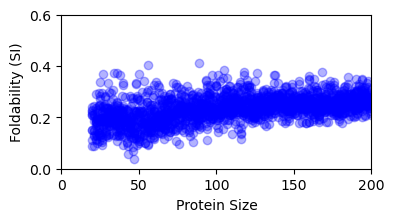

In [90]:
model = 'codesign_diffab_complete_gen_share-true_step100_lr1.e-4_wd0.0_posiscaleadapt-50.0_center_2024_09_09__22_24_59'
dict_path = os.path.join(RESULT_PATH, model, 'seq-foldability.pkl')
foldability_read(dict_path, plot = True, desired_token = '_0_')

ave_score=0.185196 for 1810 samples.


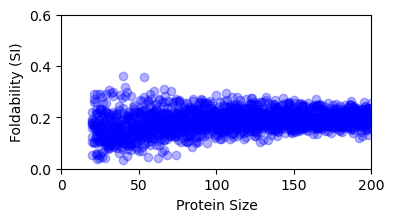

In [91]:
model = 'codesign_diffab_complete_gen_share-true_dim-256_step100_lr1.e-4_wd0.0_posiscale50.0_sc_center_2024_09_10__13_06_07'
dict_path = os.path.join(RESULT_PATH, model, 'seq-foldability.pkl')
foldability_read(dict_path, plot = True, desired_token = '_0_')

**Updated**

In [92]:
RESULT_PATH = '../../Results/jointDiff_updated/'
model_list = [m for m in os.listdir(RESULT_PATH) if m.startswith('codesign_diffab')]

*Coverged points*

In [93]:
for model in model_list:
    dict_path = os.path.join(RESULT_PATH, model, 'seq_foldability.pkl')
    if not os.path.exists(dict_path):
        continue
    d = dict_load(dict_path)
    val_list, len_list = consist_summarization_seq(d)
    
    print(model.split('share-true_')[-1])
    list_summary(val_list, title = 'Foldability')
    foldability_dict[kind][model] = {'stop': (val_list, len_list)}
    print('************************************************************')

dim-128-64-4_step100_lr1.e-4_wd0._posiscale50.0_sc_center_2024_10_22__22_31_43_loss-0-mse-0-0_uf_mse
Foldability: (1810 points) mean=0.168198, median=0.170491, min=0.013043, max=0.340909, std=0.042782
************************************************************
dim-128-64-4_step100_lr1.e-4_wd0._posiscaleadapt_sc_center_2024_10_21__21_48_21_loss-0-mse-0-0
Foldability: (1810 points) mean=0.214065, median=0.217730, min=0.000000, max=0.426087, std=0.044549
************************************************************
dim-128-64-4_step100_lr1.e-4_wd0._posiscale50.0_sc_center_2024_10_22__07_29_49_loss-1-mse-0-0_grace
Foldability: (1810 points) mean=0.208409, median=0.213537, min=0.021429, max=0.408333, std=0.051206
************************************************************
dim-128-64-4_step100_lr1.e-4_wd0._posiscale50.0_sc_center_2024_10_21__20_52_38_loss-1-mse-1-1_consist-gt-cross
Foldability: (1810 points) mean=0.216360, median=0.211339, min=0.019048, max=0.548718, std=0.066594
**********

*Last points*

In [94]:
for model in model_list:
    dict_path = os.path.join(RESULT_PATH, model, 'seq_foldability_last.pkl')
    if not os.path.exists(dict_path):
        continue
    d = dict_load(dict_path)
    val_list, len_list = consist_summarization_seq(d)
    
    print(model.split('share-true_')[-1])
    list_summary(val_list, title = 'Foldability')
    if model not in foldability_dict[kind]:
        foldability_dict[kind][model] = {}
    foldability_dict[kind][model]['last'] = (val_list, len_list)
    print('************************************************************')

dim-128-64-4_step100_lr1.e-4_wd0._posiscale50.0_sc_center_2024_10_22__22_31_43_loss-0-mse-0-0_uf_mse
Foldability: (1810 points) mean=0.171258, median=0.174225, min=0.015873, max=0.345000, std=0.042504
************************************************************
dim-128-64-4_step100_lr1.e-4_wd0._posiscaleadapt_sc_center_2024_10_21__21_48_21_loss-0-mse-0-0
Foldability: (1810 points) mean=0.224739, median=0.229435, min=0.027273, max=0.377551, std=0.049229
************************************************************
dim-128-64-4_step100_lr1.e-4_wd0._posiscale50.0_sc_center_2024_10_22__07_29_49_loss-1-mse-0-0_grace
Foldability: (1810 points) mean=0.205937, median=0.210747, min=0.028571, max=0.378355, std=0.052041
************************************************************
dim-128-64-4_step100_lr1.e-4_wd0._posiscale50.0_sc_center_2024_10_21__20_52_38_loss-1-mse-1-1_consist-gt-cross
Foldability: (1810 points) mean=0.219251, median=0.212251, min=0.003571, max=0.497886, std=0.067581
**********

ave_score=0.301140 for 1810 samples.


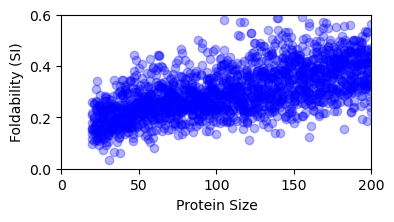

In [95]:
model = 'codesign_diffab_complete_gen_share-true_dim-256-128-2_step100_lr1.e-4_wd0._posiscaleadapt-50_sc_center_2024_10_24__20_48_33_loss-1-mse-1-1_rm_mse'
dict_path = os.path.join(RESULT_PATH, model, 'seq_foldability_last.pkl')
foldability_read(dict_path, plot = True, desired_token = '_0_')

ave_score=0.191477 for 1810 samples.


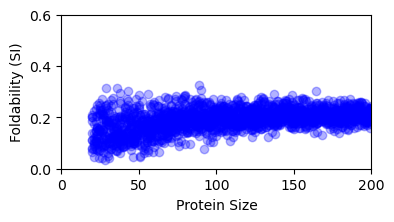

In [96]:
model = 'codesign_diffab_complete_gen_share-true_dim-128-64-4_step100_lr1.e-4_wd0._posiscale50.0_sc_center_2024_10_26__08_24_22_loss-1-mse-1-1_consist-distribution_grace'
dict_path = os.path.join(RESULT_PATH, model, 'seq_foldability_last.pkl')
foldability_read(dict_path, plot = True, desired_token = '_0_')

In [97]:
RESULT_PATH = '../../Results/jointDiff_updated_eval/'
model_list = [m for m in os.listdir(RESULT_PATH) if m.startswith('codesign_diffab')]

In [98]:
for model in model_list:
    dict_path = os.path.join(RESULT_PATH, model, 'seq_foldability.pkl')
    if not os.path.exists(dict_path):
        continue
    d = dict_load(dict_path)
    val_list, len_list = consist_summarization_seq(d)
    
    print(model.split('share-true_')[-1])
    list_summary(val_list, title = 'Foldability')
    if model not in foldability_dict[kind]:
        foldability_dict[kind][model] = {}
    foldability_dict[kind][model]['updated'] = (val_list, len_list)
    print('************************************************************')

dim-128-64-4_step100_lr1.e-4_wd0._posiscaleadapt_sc_center_2024_10_21__21_48_21_loss-0-mse-0-0
Foldability: (1810 points) mean=0.224571, median=0.228922, min=0.027273, max=0.386683, std=0.049567
************************************************************
dim-128-64-4_step100_lr1.e-4_wd0._posiscale50.0_sc_center_2024_10_21__20_52_38_loss-1-mse-1-1_consist-gt-cross
Foldability: (1810 points) mean=0.219251, median=0.212251, min=0.003571, max=0.497886, std=0.067581
************************************************************
dim-256-128-2_step100_lr1.e-4_wd0._posiscale50.0_sc_center_2024_10_24__20_48_33_loss-1-mse-1-1_rm_mse
Foldability: (1810 points) mean=0.210002, median=0.212523, min=0.029787, max=0.359168, std=0.045795
************************************************************
dim-128-64-4_step100_lr1.e-4_wd0._posiscale50.0_sc_center_2024_10_20__23_57_14_loss-1-mse-1-1
Foldability: (1810 points) mean=0.237298, median=0.245011, min=0.003846, max=0.457500, std=0.063363
***************

### LaDiff

In [104]:
kind = 'LaDiff'
foldability_dict[kind] = {}

In [105]:
RESULT_PATH = '../../Results/latentDiff/'
model_list = [m for m in os.listdir(RESULT_PATH) if m.startswith('latentdiff')]

In [106]:
for model in model_list:
    dict_path = os.path.join(RESULT_PATH, model, 'seq-foldability.pkl')
    if not os.path.exists(dict_path):
        continue
    d = dict_load(dict_path)
    val_list, len_list = consist_summarization_seq(d)
    
    print(model.split('share-true_')[-1])
    list_summary(val_list, title = 'Foldability')
    foldability_dict[kind][model] = {'stop': (val_list, len_list)}
    print('************************************************************')

latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_withMask_gt_Faster
Foldability: (740 points) mean=0.169371, median=0.155506, min=0.001818, max=0.795385, std=0.097601
************************************************************
latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_unet-2-64_withMask_gt_Faster_100steps
Foldability: (740 points) mean=0.159133, median=0.153867, min=0.000000, max=0.778378, std=0.095335
************************************************************
latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_noEnd_unet-2-32_withMask_noise_Faster_100steps
Foldability: (740 points) mean=0.124374, median=0.115207, min=0.000000, max=0.595863, std=0.074949
************************************************************
latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_noEnd_unet-2-32_withMask_gt_Faster_100steps
Foldability: (740 points) mean=0.144226, median=0.126974, min=0.000000, max=0.632000, std=0.097384
***********************************************

ave_score=0.339904 for 370 samples.


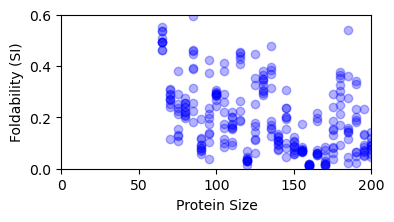

In [107]:
model = 'latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_unet-2-32_withMask_gt_len-mha_Faster_100steps'
dict_path = os.path.join('../../Results/latentDiff_updated_eval/', model, 'seq_foldability.pkl')
foldability_read(dict_path, plot = True, desired_token = '_step0_')

**Updated**

In [108]:
RESULT_PATH = '../../Results/latentDiff_updated/'
model_list = [m for m in os.listdir(RESULT_PATH) if m.startswith('latentdiff')]

In [109]:
for model in model_list:
    dict_path = os.path.join(RESULT_PATH, model, 'seq_foldability.pkl')
    if not os.path.exists(dict_path):
        continue
    d = dict_load(dict_path)
    val_list, len_list = consist_summarization_seq(d)
    
    print(model.split('share-true_')[-1])
    list_summary(val_list, title = 'Foldability')
    foldability_dict[kind][model] = {'stop': (val_list, len_list)}
    print('************************************************************')

latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_transformer-6_withMask_noise_len-mha_Faster_100steps_micro
Foldability: (610 points) mean=0.066942, median=0.062004, min=0.000000, max=0.313103, std=0.053613
************************************************************
latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_unet-2_withMask_noise_len-linear_Faster_100steps_micro
Foldability: (610 points) mean=0.066463, median=0.042312, min=0.000000, max=0.425189, std=0.073462
************************************************************
latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_unet-2_withMask_noise_len-none_Faster_100steps_micro
Foldability: (610 points) mean=0.174520, median=0.172526, min=0.010000, max=0.434578, std=0.060396
************************************************************
latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_unet-2_withMask_gt_len-mha_Faster_100steps_rm_frag_micro_withSeqDecoder-0

In [110]:
RESULT_PATH = '../../Results/latentDiff_updated_eval/'
model_list = [m for m in os.listdir(RESULT_PATH) if m.startswith('latentdiff')]

In [111]:
for model in model_list:
    dict_path = os.path.join(RESULT_PATH, model, 'seq_foldability.pkl')
    if not os.path.exists(dict_path):
        continue
    d = dict_load(dict_path)
    val_list, len_list = consist_summarization_seq(d)
    
    print(model.split('share-true_')[-1])
    list_summary(val_list, title = 'Foldability')
    foldability_dict[kind][model] = {'stop': (val_list, len_list)}
    print('************************************************************')

latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_unet-2_withMask_gt_len-mha_Faster_100steps_rm_frag_micro_withSeqDecoder-1.0-10.0
Foldability: (610 points) mean=0.064223, median=0.048222, min=0.000000, max=0.457692, std=0.061529
************************************************************
latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_unet-2_withMask_gt_len-mha_Faster_100steps_micro_withSeqDecoder-1.0-1.0
Foldability: (610 points) mean=0.201521, median=0.172822, min=0.001613, max=0.656923, std=0.132039
************************************************************
latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_unet-2_withMask_gt_len-none_Faster_100steps_rm_frag_micro_withSeqDecoder-1.0-10.0
Foldability: (610 points) mean=0.128681, median=0.125390, min=0.000000, max=0.418919, std=0.074222
************************************************************
latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_unet-

In [112]:
for model in model_list:
    dict_path = os.path.join(RESULT_PATH, model, 'seq_foldability_last.pkl')
    if not os.path.exists(dict_path):
        continue
    d = dict_load(dict_path)
    val_list, len_list = consist_summarization_seq(d)
    
    print(model.split('share-true_')[-1])
    list_summary(val_list, title = 'Foldability')
    if model not in foldability_dict[kind]:
        foldability_dict[kind][model] = {}
    foldability_dict[kind][model]['last'] = (val_list, len_list)
    print('************************************************************')

latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_unet-2-32_withMask_gt_len-linear_Faster_100steps
Foldability: (1810 points) mean=0.170999, median=0.161774, min=0.000000, max=0.893933, std=0.099227
************************************************************
latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_unet-2-64_withMask_gt_len-linear_Faster_100steps
Foldability: (1810 points) mean=0.170646, median=0.175361, min=0.002857, max=0.406897, std=0.059896
************************************************************
latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_unet-2-64_withMask_gt_len-mha_Faster_100steps
Foldability: (1810 points) mean=0.253718, median=0.194539, min=0.002667, max=0.791304, std=0.193598
************************************************************
latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_transformer-6_withMask_gt_len-linear_Faster_100steps
Foldability: (1810 points) mean=0.141723

### LaDiff-DiT

In [132]:
kind = 'LaDiff-DiT'
foldability_dict[kind] = {}

RESULT_PATH = os.path.join(OVERALL_PATH, 'latentDiff_DiT_warm')
model_list = [m for m in os.listdir(RESULT_PATH) if 'DiT' in m]

for model in model_list:
    print(model)
    
    for token in [
        'ddpm', 'ddim', 'ddpm-uncon-guide', 
        'ddpm_last', 'ddim_last', 'ddpm-uncon-guide_last',
        'ddpm_last-2', 'ddim_last-2', 'ddpm-uncon-guide_last2'
    ]:
        dict_path = os.path.join(RESULT_PATH, model, 'seq_foldability_%s.pkl' % token)
        if not os.path.exists(dict_path):
            continue
        d = dict_load(dict_path)
        val_list, len_list = consist_summarization_seq(d)
        
        list_summary(val_list, title = '(%s) Foldability' % token)
        if model not in foldability_dict[kind]:
            foldability_dict[kind][model] = {}
        foldability_dict[kind][model][token] = (val_list, len_list)
    print('************************************************************')

005-DiT-M-withLen-withMask_diff-linear-500_warm_withLenClus_bin10_upsampling_warm
(ddpm-uncon-guide_last) Foldability: (488 points) mean=0.246704, median=0.225926, min=0.013043, max=0.614634, std=0.108707
(ddpm-uncon-guide_last2) Foldability: (488 points) mean=0.252549, median=0.222423, min=0.008933, max=0.632927, std=0.123749
************************************************************
004-DiT-M-withLen-withMask_diff-linear-500_warm_withLenClus_bin5_upsampling_warm
(ddpm-uncon-guide_last) Foldability: (488 points) mean=0.243829, median=0.217732, min=0.004348, max=0.611585, std=0.106311
(ddpm-uncon-guide_last2) Foldability: (488 points) mean=0.247261, median=0.218987, min=0.047826, max=0.629907, std=0.109820
************************************************************
000-DiT-M-withLen-withMask_diff-linear-500_warm_withLenClus_bin5_warm_updated
(ddpm-uncon-guide_last) Foldability: (488 points) mean=0.238673, median=0.215139, min=0.021739, max=0.613415, std=0.104846
(ddpm-uncon-guide_la

## Designability (structure)

In [100]:
designability_dict = {}

### Baselines

In [101]:
kind = 'baseline'
designability_dict[kind] = {}

In [102]:
RESULT_PATH = os.path.join(OVERALL_PATH, 'Baselines')
model_list = ['Nature', 'foldingdiff', 'RFdiffusion', 'Chroma', 'protein_generator']
#model_list = ['Nature', 'RFdiffusion', 'Chroma', 'protein_generator']

In [103]:
d = dict_load('../../Results/Baselines/protein_generator/designability_dict.pkl')

In [104]:
for model in model_list:
    dict_path = os.path.join(RESULT_PATH, model, 'designability_dict.pkl')
    if not os.path.exists(dict_path):
        continue
    d = dict_load(dict_path)
    tmscore_list, rmsd_list, len_list = consist_summarization_struc(d)
    if not tmscore_list:
        continue
    print(model.split('share-true_')[-1])
    list_summary(tmscore_list, title = 'TM-score')
    list_summary(rmsd_list, title = 'RMSD', max_thre = 2.0)
    designability_dict[kind][model] = {'stop': (tmscore_list, rmsd_list, len_list)}
    print('************************************************************')

Nature
TM-score: (155 points) mean=0.858573, median=0.920596, min=0.228770, max=0.989046, std=0.150602
RMSD: (155 points) mean=1.458206, median=1.266000, min=0.410000, max=4.796000, std=0.789608, succ_ratio=0.800000
************************************************************
foldingdiff
TM-score: (110 points) mean=0.368492, median=0.312827, min=0.117698, max=0.817258, std=0.196874
RMSD: (110 points) mean=2.892064, median=2.982000, min=0.374000, max=5.168000, std=1.185854, succ_ratio=0.290909
************************************************************
RFdiffusion
TM-score: (183 points) mean=0.888081, median=0.926650, min=0.450422, max=0.987834, std=0.110582
RMSD: (183 points) mean=1.125956, median=0.946000, min=0.180000, max=4.600000, std=0.723508, succ_ratio=0.912568
************************************************************
Chroma
TM-score: (185 points) mean=0.670397, median=0.692632, min=0.290004, max=0.963818, std=0.166155
RMSD: (185 points) mean=2.451146, median=2.254000, min=0

### JointDiff

In [105]:
kind = 'JointDiff'
designability_dict[kind] = {}

**Original**

In [106]:
RESULT_PATH = '../../Results/jointDiff'
model_list = [m for m in os.listdir(RESULT_PATH) if m.startswith('codesign_diffab')]

In [107]:
for model in model_list:
    dict_path = os.path.join(RESULT_PATH, model, 'designability_esmfold_TMscore_dict.pkl')
    if not os.path.exists(dict_path):
        continue
    d = dict_load(dict_path)
    tmscore_list, rmsd_list, len_list = consist_summarization_struc(d)
    
    print(model.split('share-true_')[-1])
    list_summary(tmscore_list, title = 'TM-score')
    list_summary(rmsd_list, title = 'RMSD', max_thre = 2.0)
    designability_dict[kind][model] = {'stop': (tmscore_list, rmsd_list, len_list)}
    print('************************************************************')

step100_lr1.e-4_wd0.0_posiscale10.0_2024_09_02__20_50_44
TM-score: (185 points) mean=0.548396, median=0.534574, min=0.328746, max=0.839270, std=0.125009
RMSD: (185 points) mean=3.099838, median=2.996000, min=0.734000, max=5.546000, std=1.208871, succ_ratio=0.183784
************************************************************
step100_lr1.e-4_wd0.0_posiscaleadapt-20.0_center_2024_09_09__22_25_17
TM-score: (110 points) mean=0.490544, median=0.591816, min=0.065824, max=0.866520, std=0.236861
RMSD: (110 points) mean=2.757573, median=2.673000, min=0.910000, max=5.212000, std=1.178263, succ_ratio=0.290909
************************************************************
step100_lr1.e-4_wd0.0_posiscale50.0_sc_center_2024_09_08__22_02_11
TM-score: (185 points) mean=0.364687, median=0.294818, min=0.119648, max=0.797540, std=0.166652
RMSD: (185 points) mean=3.765454, median=4.040000, min=1.174000, max=6.168000, std=1.348279, succ_ratio=0.162162
*********************************************************

**Updated**

In [108]:
RESULT_PATH = '../../Results/jointDiff_updated/'
model_list = [m for m in os.listdir(RESULT_PATH) if m.startswith('codesign_diffab')]

In [109]:
for model in model_list:
    dict_path = os.path.join(RESULT_PATH, model, 'designability_dict.pkl')
    if not os.path.exists(dict_path):
        continue
    d = dict_load(dict_path)
    tmscore_list, rmsd_list, len_list = consist_summarization_struc(d)
    
    print(model.split('share-true_')[-1])
    list_summary(tmscore_list, title = 'TM-score')
    list_summary(rmsd_list, title = 'RMSD', max_thre = 2.0)
    designability_dict[kind][model] = {'stop': (tmscore_list, rmsd_list, len_list)}
    print('************************************************************')

dim-128-64-4_step100_lr1.e-4_wd0._posiscale50.0_sc_center_2024_10_22__22_31_43_loss-0-mse-0-0_uf_mse
TM-score: (185 points) mean=0.391800, median=0.386040, min=0.096102, max=0.686344, std=0.110984
RMSD: (185 points) mean=3.494897, median=3.684000, min=1.390000, max=5.620000, std=1.128724, succ_ratio=0.178378
************************************************************
dim-128-64-4_step100_lr1.e-4_wd0._posiscaleadapt_sc_center_2024_10_21__21_48_21_loss-0-mse-0-0
TM-score: (185 points) mean=0.514865, median=0.503970, min=0.288126, max=0.814426, std=0.119421
RMSD: (185 points) mean=3.300108, median=3.404000, min=0.804000, max=5.558000, std=1.237108, succ_ratio=0.210811
************************************************************
dim-128-64-4_step100_lr1.e-4_wd0._posiscale50.0_sc_center_2024_10_22__07_29_49_loss-1-mse-0-0_grace
TM-score: (185 points) mean=0.157430, median=0.157380, min=0.091840, max=0.222420, std=0.024521
RMSD: (185 points) mean=3.934205, median=4.150000, min=1.860000, max

In [110]:
for model in model_list:
    dict_path = os.path.join(RESULT_PATH, model, 'designability_last_dict.pkl')
    if not os.path.exists(dict_path):
        continue
    d = dict_load(dict_path)
    tmscore_list, rmsd_list, len_list = consist_summarization_struc(d)
    
    print(model.split('share-true_')[-1])
    list_summary(tmscore_list, title = 'TM-score')
    list_summary(rmsd_list, title = 'RMSD', max_thre = 2.0)
    if model not in designability_dict[kind]:
        designability_dict[kind][model] = {}
    designability_dict[kind][model]['last'] = (tmscore_list, rmsd_list, len_list)
    print('************************************************************')

dim-128-64-4_step100_lr1.e-4_wd0._posiscale50.0_sc_center_2024_10_22__22_31_43_loss-0-mse-0-0_uf_mse
TM-score: (185 points) mean=0.411685, median=0.392938, min=0.107418, max=0.763102, std=0.151247
RMSD: (185 points) mean=3.504973, median=3.692000, min=1.304000, max=5.828000, std=1.219594, succ_ratio=0.183784
************************************************************
dim-128-64-4_step100_lr1.e-4_wd0._posiscaleadapt_sc_center_2024_10_21__21_48_21_loss-0-mse-0-0
TM-score: (185 points) mean=0.551990, median=0.544336, min=0.292974, max=0.859948, std=0.125741
RMSD: (185 points) mean=3.116519, median=3.020000, min=0.910000, max=5.380000, std=1.125167, succ_ratio=0.189189
************************************************************
dim-128-64-4_step100_lr1.e-4_wd0._posiscale50.0_sc_center_2024_10_22__07_29_49_loss-1-mse-0-0_grace
TM-score: (185 points) mean=0.153189, median=0.147630, min=0.099510, max=0.247650, std=0.028712
RMSD: (185 points) mean=3.873081, median=4.178000, min=1.706000, max

In [111]:
RESULT_PATH = '../../Results/jointDiff_updated_eval/'
model_list = [m for m in os.listdir(RESULT_PATH) if m.startswith('codesign_diffab')]

In [112]:
for model in model_list:
    dict_path = os.path.join(RESULT_PATH, model, 'designability_esmfold_TMscore_dict.pkl')
    if not os.path.exists(dict_path):
        continue
    d = dict_load(dict_path)
    tmscore_list, rmsd_list, len_list = consist_summarization_struc(d)
    
    print(model.split('share-true_')[-1])
    list_summary(tmscore_list, title = 'TM-score')
    list_summary(rmsd_list, title = 'RMSD', max_thre = 2.0)
    if model not in designability_dict[kind]:
        designability_dict[kind][model] = {}
    designability_dict[kind][model]['updated'] = (tmscore_list, rmsd_list, len_list)
    print('************************************************************')

dim-128-64-4_step100_lr1.e-4_wd0._posiscaleadapt_sc_center_2024_10_21__21_48_21_loss-0-mse-0-0
TM-score: (185 points) mean=0.551550, median=0.538106, min=0.292928, max=0.859916, std=0.125407
RMSD: (185 points) mean=3.123178, median=3.000000, min=0.910000, max=5.196000, std=1.126243, succ_ratio=0.183784
************************************************************
dim-128-64-4_step100_lr1.e-4_wd0._posiscale50.0_sc_center_2024_10_21__20_52_38_loss-1-mse-1-1_consist-gt-cross
TM-score: (185 points) mean=0.592652, median=0.606102, min=0.312784, max=0.877238, std=0.106949
RMSD: (185 points) mean=2.763946, median=2.712000, min=0.920000, max=5.178000, std=0.977715, succ_ratio=0.243243
************************************************************
dim-256-128-2_step100_lr1.e-4_wd0._posiscale50.0_sc_center_2024_10_24__20_48_33_loss-1-mse-1-1_rm_mse
TM-score: (185 points) mean=0.575155, median=0.567194, min=0.221744, max=0.933424, std=0.148290
RMSD: (185 points) mean=2.846459, median=2.936000, min=0

### LaDiff

In [126]:
kind = 'LaDiff'
designability_dict[kind] = {}

In [127]:
RESULT_PATH = '../../Results/latentDiff/'
model_list = [m for m in os.listdir(RESULT_PATH) if m.startswith('latent')]

In [128]:
for model in model_list:
    dict_path = os.path.join(RESULT_PATH, model, 'designability_esmfold_TMscore_dict.pkl')
    if not os.path.exists(dict_path):
        continue
    d = dict_load(dict_path)
    tmscore_list, rmsd_list, len_list = consist_summarization_struc(d)
    
    print(model.split('share-true_')[-1])
    list_summary(tmscore_list, title = 'TM-score')
    list_summary(rmsd_list, title = 'RMSD', max_thre = 2.0)
    designability_dict[kind][model] = {'stop': (tmscore_list, rmsd_list, len_list)}
    print('************************************************************')

latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_withMask_gt_Faster
TM-score: (740 points) mean=0.280264, median=0.266350, min=0.098270, max=0.944610, std=0.097617
RMSD: (740 points) mean=4.043682, median=4.220000, min=0.270000, max=6.460000, std=1.284211, succ_ratio=0.083784
************************************************************
latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_unet-2-64_withMask_gt_Faster_100steps
TM-score: (740 points) mean=0.309653, median=0.296805, min=0.112460, max=0.946455, std=0.097516
RMSD: (740 points) mean=3.915770, median=4.050000, min=0.130000, max=6.850000, std=1.207342, succ_ratio=0.072973
************************************************************
latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_noEnd_unet-2-32_withMask_noise_Faster_100steps
TM-score: (740 points) mean=0.305821, median=0.280115, min=0.114830, max=0.870090, std=0.106685
RMSD: (740 points) mean=4.000932, median=4.260000, min=0.340000, max=6.490000, std=1.302

**Updated**

In [129]:
RESULT_PATH = '../../Results/latentDiff_updated/'
model_list = [m for m in os.listdir(RESULT_PATH) if m.startswith('latent')]

In [130]:
for model in model_list:
    dict_path = os.path.join(RESULT_PATH, model, 'designability_dict.pkl')
    if not os.path.exists(dict_path):
        continue
    d = dict_load(dict_path)
    tmscore_list, rmsd_list, len_list = consist_summarization_struc(d)
    
    print(model.split('share-true_')[-1])
    list_summary(tmscore_list, title = 'TM-score')
    list_summary(rmsd_list, title = 'RMSD', max_thre = 2.0)
    designability_dict[kind][model] = {'stop': (tmscore_list, rmsd_list, len_list)}
    print('************************************************************')

latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_transformer-6_withMask_noise_len-mha_Faster_100steps_micro
TM-score: (305 points) mean=0.228748, median=0.195572, min=0.063762, max=0.851434, std=0.131609
RMSD: (305 points) mean=4.493144, median=4.876000, min=0.464000, max=7.010000, std=1.483656, succ_ratio=0.049180
************************************************************
latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_unet-2_withMask_noise_len-linear_Faster_100steps_micro
TM-score: (305 points) mean=0.288364, median=0.219966, min=0.127128, max=0.841978, std=0.151841
RMSD: (305 points) mean=4.054236, median=4.244000, min=0.296000, max=6.320000, std=1.435971, succ_ratio=0.108197
************************************************************
latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_unet-2_withMask_noise_len-none_Faster_100steps_micro
TM-score: (305 points) mean=0.415367, median=0.388068, min=0.135202, max=0.936488, 

In [131]:
RESULT_PATH = '../../Results/latentDiff_updated_eval/'
model_list = [m for m in os.listdir(RESULT_PATH) if m.startswith('latent')]

In [132]:
for model in model_list:
    dict_path = os.path.join(RESULT_PATH, model, 'designability_dict.pkl')
    if not os.path.exists(dict_path):
        continue
    d = dict_load(dict_path)
    tmscore_list, rmsd_list, len_list = consist_summarization_struc(d)
    
    print(model.split('share-true_')[-1])
    list_summary(tmscore_list, title = 'TM-score')
    list_summary(rmsd_list, title = 'RMSD', max_thre = 2.0)
    designability_dict[kind][model] = {'stop': (tmscore_list, rmsd_list, len_list)}
    print('************************************************************')

latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_unet-2_withMask_gt_len-mha_Faster_100steps_rm_frag_micro_withSeqDecoder-1.0-10.0
TM-score: (305 points) mean=0.337310, median=0.263300, min=0.135986, max=0.707418, std=0.141742
RMSD: (305 points) mean=4.099695, median=4.428000, min=1.720000, max=6.102000, std=1.361379, succ_ratio=0.032787
************************************************************
latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_unet-2_withMask_gt_len-mha_Faster_100steps_micro_withSeqDecoder-1.0-1.0
TM-score: (305 points) mean=0.344857, median=0.280918, min=0.146080, max=0.759068, std=0.145479
RMSD: (305 points) mean=3.869216, median=3.944000, min=1.272000, max=6.034000, std=1.407477, succ_ratio=0.108197
************************************************************
latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_unet-2_withMask_gt_len-none_Faster_100steps_rm_frag_micro_withSeqDecoder-1.0-10.0
TM-score: (305 

*Last points*

In [133]:
for model in model_list:
    dict_path = os.path.join(RESULT_PATH, model, 'designability_last_dict.pkl')
    if not os.path.exists(dict_path):
        continue
    d = dict_load(dict_path)
    tmscore_list, rmsd_list, len_list = consist_summarization_struc(d)
    
    print(model.split('share-true_')[-1])
    list_summary(tmscore_list, title = 'TM-score')
    list_summary(rmsd_list, title = 'RMSD', max_thre = 2.0)
    if model not in designability_dict[kind]:
        designability_dict[kind][model] = {}
    designability_dict[kind][model]['last'] = (tmscore_list, rmsd_list, len_list)
    print('************************************************************')

latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_unet-2-32_withMask_gt_len-linear_Faster_100steps
TM-score: (185 points) mean=0.430682, median=0.388308, min=0.139412, max=0.928614, std=0.176448
RMSD: (185 points) mean=3.293914, median=3.414000, min=0.362000, max=5.724000, std=1.411461, succ_ratio=0.237838
************************************************************
latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_unet-2-64_withMask_gt_len-linear_Faster_100steps
TM-score: (185 points) mean=0.468183, median=0.445860, min=0.182266, max=0.951370, std=0.153678
RMSD: (185 points) mean=3.329232, median=3.468000, min=0.338000, max=5.464000, std=1.154076, succ_ratio=0.124324
************************************************************
latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_unet-2-64_withMask_gt_len-mha_Faster_100steps
TM-score: (185 points) mean=0.340070, median=0.302502, min=0.134120, max=0.839624, std=0.147871
RMSD: (185

### LaDiff-DiT

In [127]:
kind = 'LaDiff-DiT'
designability_dict[kind] = {}

RESULT_PATH = os.path.join(OVERALL_PATH, 'latentDiff_DiT_warm')
model_list = [m for m in os.listdir(RESULT_PATH) if 'DiT' in m]

for model in model_list:
    print(model)
    
    for token in [
        'ddpm', 'ddim', 'ddpm-uncon-guide', 
        'ddpm_last', 'ddim_last', 'ddpm-uncon-guide_last',
        'ddpm_last-2', 'ddim_last-2', 'ddpm-uncon-guide_last2'
    ]:
        dict_path = os.path.join(RESULT_PATH, model, 'designability_esmfold_%s_TMscore_dict.pkl' % token)
        if not os.path.exists(dict_path):
            continue
        d = dict_load(dict_path)
        tmscore_list, rmsd_list, len_list = consist_summarization_struc(d)
        
        list_summary(tmscore_list, title = '(%s) TM-score' % token)
        list_summary(rmsd_list, title = '(%s) RMSD' % token, max_thre = 2.0)
        if model not in designability_dict[kind]:
            designability_dict[kind][model] = {}
        designability_dict[kind][model][token] = (tmscore_list, rmsd_list, len_list)
    print('************************************************************')

005-DiT-M-withLen-withMask_diff-linear-500_warm_withLenClus_bin10_upsampling_warm
(ddpm-uncon-guide_last) TM-score: (305 points) mean=0.575245, median=0.510228, min=0.209158, max=0.991384, std=0.237031
(ddpm-uncon-guide_last) RMSD: (305 points) mean=2.961889, median=3.142000, min=0.214000, max=5.790000, std=1.554078, succ_ratio=0.324590
(ddpm-uncon-guide_last2) TM-score: (305 points) mean=0.598198, median=0.547092, min=0.178862, max=0.992122, std=0.235320
(ddpm-uncon-guide_last2) RMSD: (305 points) mean=2.863639, median=2.976000, min=0.170000, max=5.854000, std=1.565758, succ_ratio=0.331148
************************************************************
004-DiT-M-withLen-withMask_diff-linear-500_warm_withLenClus_bin5_upsampling_warm
(ddpm-uncon-guide_last) TM-score: (305 points) mean=0.572431, median=0.507336, min=0.201444, max=0.991026, std=0.229918
(ddpm-uncon-guide_last) RMSD: (305 points) mean=2.979430, median=3.098000, min=0.202000, max=5.930000, std=1.517182, succ_ratio=0.318033
(dd

# Summary

In [114]:
# feature_dict
# consist_seq_dict
# consist_struc_dict
# foldability_dict
# designability_dict

kind_set = set(feature_dict.keys())
kind_set = kind_set.union(set(consist_seq_dict.keys()))
kind_set = kind_set.union(set(consist_struc_dict.keys()))
kind_set = kind_set.union(set(foldability_dict.keys()))
kind_set = kind_set.union(set(designability_dict.keys()))

model_dict = {}
for kind in kind_set:
    model_dict[kind] = set()
    if kind in feature_dict:
        model_dict[kind] = model_dict[kind].union(set(feature_dict[kind].keys()))
    if kind in consist_seq_dict:
        model_dict[kind] = model_dict[kind].union(set(consist_seq_dict[kind].keys()))
    if kind in consist_struc_dict:
        model_dict[kind] = model_dict[kind].union(set(consist_struc_dict[kind].keys()))
    if kind in foldability_dict:
        model_dict[kind] = model_dict[kind].union(set(foldability_dict[kind].keys()))
    if kind in designability_dict:
        model_dict[kind] = model_dict[kind].union(set(designability_dict[kind].keys()))
    print(kind, '%d models.' % len(model_dict[kind]))

baseline 5 models.
LaDiff-DiT 6 models.
LaDiff 11 models.
JointDiff 88 models.


In [116]:
designability_dict['LaDiff-DiT'].keys()

dict_keys(['005-DiT-M-withLen-withMask_diff-linear-500_warm_withLenClus_bin10_upsampling_warm', '004-DiT-M-withLen-withMask_diff-linear-500_warm_withLenClus_bin5_upsampling_warm', '000-DiT-M-withLen-withMask_diff-linear-500_warm_withLenClus_bin5_warm_updated', '002-DiT-M-withLen-withMask_diff-linear-500_warm_withLenClus_bin10_upsampling-smote_warm', '001-DiT-M-withLen-withMask_diff-linear-500_warm_withLenClus_bin10_warm_updated'])

## Baselines

In [155]:
kind_summary('baseline', model_list = None)

baseline
##############################################################
RFdiffusion
**********************************************************
stop: Designability-TMscore: (183 points) mean=0.888081, median=0.926650, min=0.450422, max=0.987834, std=0.110582
stop: Designability-RMSD: (183 points) mean=1.125956, median=0.946000, min=0.180000, max=4.600000, std=0.723508, succ_ratio=0.912568
stop: Clash: (1792 points) mean=1.222098, median=0.000000, min=0.000000, max=14.000000, std=1.850978
stop: Repeat (100.00%): (1792 points) mean=1.000000, median=1.000000, min=1.000000, max=1.000000, std=0.000000
stop: Max-repeat: (1792 points) mean=1.000000, median=1.000000, min=1.000000, max=1.000000, std=0.000000

Chroma
**********************************************************
stop: Consistency-seq: (1810 points) mean=0.326785, median=0.328479, min=0.042532, max=0.603571, std=0.084767
stop: Consistency-struc-TMscore: (1810 points) mean=0.768605, median=0.822895, min=0.160390, max=0.973610, std=0.16

## JointDiff

**Uncentered-DDPM**

In [202]:
kind = 'JointDiff'
model_list = sorted([
    m for m in model_dict[kind] if ('center' not in m) and ('loss' not in m) and ('_sc_' not in m) and ('2024_09_' not in m)
])

kind_summary(kind, model_list)

JointDiff
##############################################################
codesign_diffab_complete_gen_share-true_step100_lr1.e-4_wd0.0_2023_05_01__17_05_48
**********************************************************
stop: Consistency-seq: (1810 points) mean=0.193742, median=0.197812, min=0.019231, max=0.319048, std=0.037080
stop: Consistency-struc-TMscore: (1810 points) mean=0.353817, median=0.317595, min=0.080350, max=0.916050, std=0.134168
stop: Consistency-struc-RMSD: (1810 points) mean=3.546718, median=3.745000, min=0.260000, max=6.460000, std=1.324806, succ_ratio=0.149724
stop: Foldability: (1810 points) mean=0.227991, median=0.233213, min=0.052381, max=0.419864, std=0.053575
stop: Designability-TMscore: (185 points) mean=0.389860, median=0.346906, min=0.105236, max=0.880702, std=0.148416
stop: Designability-RMSD: (185 points) mean=3.307827, median=3.404000, min=0.402000, max=5.420000, std=1.233302, succ_ratio=0.156757
stop: Clash: (1810 points) mean=11.954144, median=8.000000, min

**Centered-DDPM**

In [203]:
kind = 'JointDiff'
model_list = sorted([
    m for m in model_dict[kind] if ('center' in m or '2024_09_' in m) and ('loss' not in m) and ('_sc_' not in m)
])

kind_summary(kind, model_list)

JointDiff
##############################################################
codesign_diffab_complete_gen_share-true_dim-256_step100_lr1.e-4_wd0.0_posiscale50.0_center_2024_09_10__11_30_09
**********************************************************
stop: Consistency-struc-TMscore: (1810 points) mean=0.549295, median=0.515320, min=0.188230, max=0.922830, std=0.146474
stop: Consistency-struc-RMSD: (1810 points) mean=2.989834, median=3.210000, min=0.340000, max=5.930000, std=1.369588, succ_ratio=0.269613
stop: Foldability: (5430 points) mean=0.215443, median=0.220788, min=0.036000, max=0.414542, std=0.052437
stop: Designability-TMscore: (185 points) mean=0.528365, median=0.519242, min=0.158238, max=0.875281, std=0.166682
stop: Designability-RMSD: (185 points) mean=3.040957, median=3.190000, min=0.564000, max=5.690000, std=1.146977, succ_ratio=0.205405
stop: Repeat (7.51%): (5430 points) mean=0.005841, median=0.000000, min=0.000000, max=0.287582, std=0.025193
stop: Max-repeat: (5430 points) mea

**Centered-SC**

In [204]:
kind = 'JointDiff'
model_list = sorted([
    m for m in model_dict[kind] if ('center' in m) and ('loss' not in m) and ('_sc_' in m)
])

kind_summary(kind, model_list)

JointDiff
##############################################################
codesign_diffab_complete_gen_share-true_dim-256_step100_lr1.e-4_wd0.0_posiscale100.0_sc_center_2024_09_10__13_06_07
**********************************************************
stop: Consistency-seq: (1329 points) mean=0.077831, median=0.075910, min=0.000000, max=0.213907, std=0.034098
stop: Consistency-struc-TMscore: (489 points) mean=0.313140, median=0.299300, min=0.076290, max=0.681180, std=0.107240
stop: Consistency-struc-RMSD: (489 points) mean=2.409652, median=2.340000, min=0.970000, max=5.280000, std=0.773331, succ_ratio=0.339468
stop: Foldability: (1465 points) mean=0.154542, median=0.151429, min=0.005882, max=0.423333, std=0.057334
stop: Designability-TMscore: (110 points) mean=0.308746, median=0.239692, min=0.078724, max=0.662080, std=0.147926
stop: Designability-RMSD: (110 points) mean=3.484345, median=3.793000, min=1.314000, max=5.400000, std=1.089505, succ_ratio=0.154545
stop: Clash: empty!
stop: Repeat

In [205]:
kind = 'JointDiff'
model_list = sorted([
    m for m in model_dict[kind] if ('center' in m) and ('loss-0-mse-0-0' in m) and ('_sc_' in m)
])

kind_summary(kind, model_list)

JointDiff
##############################################################
codesign_diffab_complete_gen_share-true_dim-128-64-4_step100_lr1.e-4_wd0._posiscale10.0_sc_center_2024_10_20__23_57_14_loss-0-mse-0-0
**********************************************************
stop: Consistency-seq: (1810 points) mean=0.162221, median=0.170254, min=0.011704, max=0.259768, std=0.036579
stop: Consistency-struc-TMscore: (1810 points) mean=0.314355, median=0.311125, min=0.092110, max=0.590030, std=0.057597
stop: Consistency-struc-RMSD: (1810 points) mean=4.176920, median=4.360000, min=0.470000, max=6.550000, std=1.168067, succ_ratio=0.053591
stop: Foldability: (1810 points) mean=0.197964, median=0.201651, min=0.022222, max=0.395455, std=0.048293
stop: Designability-TMscore: (185 points) mean=0.537989, median=0.503322, min=0.171538, max=0.941748, std=0.156550
stop: Designability-RMSD: (185 points) mean=3.130184, median=2.866000, min=1.106000, max=5.596000, std=1.178547, succ_ratio=0.227027
stop: Clash:

**Updated-SC**

In [206]:
kind = 'JointDiff'
model_list = sorted([
    m for m in model_dict[kind] if ('center' in m) and ('loss' in m) and ('_sc_' in m) \
    and 'loss-0-mse-0-0' not in m and 'posiscale10.0' in m
])

kind_summary(kind, model_list)

JointDiff
##############################################################
codesign_diffab_complete_gen_share-true_dim-128-64-4_step100_lr1.e-4_wd0._posiscale10.0_sc_center_2024_10_21__23_49_44_loss-1-mse-0-0_grace
**********************************************************
stop: Consistency-seq: (1810 points) mean=0.201796, median=0.203144, min=0.048923, max=0.392414, std=0.048925
stop: Consistency-struc-TMscore: (1810 points) mean=0.353653, median=0.334420, min=0.100530, max=0.946660, std=0.112071
stop: Consistency-struc-RMSD: (1810 points) mean=3.514425, median=3.710000, min=0.250000, max=6.260000, std=1.289073, succ_ratio=0.158564
stop: Foldability: (1810 points) mean=0.224658, median=0.226185, min=0.023379, max=0.432568, std=0.066669
stop: Designability-TMscore: (185 points) mean=0.482473, median=0.464630, min=0.315480, max=0.856992, std=0.110788
stop: Designability-RMSD: (185 points) mean=3.488508, median=3.704000, min=0.310000, max=5.642000, std=1.272600, succ_ratio=0.145946
stop: 

In [207]:
kind = 'JointDiff'
model_list = sorted([
    m for m in model_dict[kind] if ('center' in m) and ('loss' in m) and ('_sc_' in m) \
    and 'loss-0-mse-0-0' not in m and 'posiscale50.0' in m
])

kind_summary(kind, model_list)

JointDiff
##############################################################
codesign_diffab_complete_gen_share-true_dim-128-64-4_step100_lr1.e-4_wd0._posiscale50.0_sc_center_2024_10_20__23_57_14_loss-1-l1-1-1
**********************************************************
stop: Consistency-seq: (1810 points) mean=0.239029, median=0.247370, min=0.050000, max=0.430952, std=0.057679
stop: Consistency-struc-TMscore: (1810 points) mean=0.444025, median=0.431445, min=0.092250, max=0.817700, std=0.139318
stop: Consistency-struc-RMSD: (1810 points) mean=3.155354, median=3.315000, min=0.460000, max=5.740000, std=1.241731, succ_ratio=0.234254
stop: Foldability: (1810 points) mean=0.295718, median=0.301856, min=0.022727, max=0.446233, std=0.052184
stop: Designability-TMscore: (185 points) mean=0.572799, median=0.564676, min=0.348328, max=0.879542, std=0.107925
stop: Designability-RMSD: (185 points) mean=2.988562, median=3.044000, min=0.862000, max=4.764000, std=1.027915, succ_ratio=0.216216
stop: Clash: 

In [208]:
kind = 'JointDiff'
model_list = sorted([
    m for m in model_dict[kind] if ('center' in m) and ('loss' in m) and ('_sc_' in m) \
    and 'loss-0-mse-0-0' not in m and 'posiscale50.0' in m and '_rm' in m
])

kind_summary(kind, model_list)

JointDiff
##############################################################
codesign_diffab_complete_gen_share-true_dim-128-64-4_step100_lr1.e-4_wd0._posiscale50.0_sc_center_2024_10_24__20_48_33_loss-1-mse-1-1_rm_mse
**********************************************************
stop: Consistency-seq: (1810 points) mean=0.171315, median=0.170975, min=0.028202, max=0.401316, std=0.044297
stop: Consistency-struc-TMscore: (1810 points) mean=0.496485, median=0.479755, min=0.185790, max=0.857030, std=0.110911
stop: Consistency-struc-RMSD: (1810 points) mean=3.171075, median=3.325000, min=0.490000, max=6.110000, std=1.279961, succ_ratio=0.217127
stop: Foldability: (1810 points) mean=0.206107, median=0.212263, min=0.037879, max=0.360345, std=0.053122
stop: Designability-TMscore: (185 points) mean=0.533198, median=0.538532, min=0.230658, max=0.847047, std=0.124127
stop: Designability-RMSD: (185 points) mean=3.089081, median=3.242000, min=0.568000, max=5.456000, std=1.152353, succ_ratio=0.183784
stop:

In [209]:
kind = 'JointDiff'
model_list = sorted([
    m for m in model_dict[kind] if ('center' in m) and ('loss' in m) and ('_sc_' in m) \
    and 'loss-0-mse-0-0' not in m and 'posiscaleadapt' in m and 'posiscaleadapt-' not in m
])

kind_summary(kind, model_list)

JointDiff
##############################################################
codesign_diffab_complete_gen_share-true_dim-128-64-4_step100_lr1.e-4_wd0._posiscaleadapt_sc_center_2024_10_21__21_48_21_loss-1-mse-1-1
**********************************************************
stop: Consistency-seq: (1810 points) mean=0.119255, median=0.121646, min=0.000000, max=0.219581, std=0.028280
stop: Consistency-struc-TMscore: (1810 points) mean=0.309682, median=0.309830, min=0.067360, max=0.681420, std=0.063582
stop: Consistency-struc-RMSD: (1810 points) mean=4.274354, median=4.450000, min=0.460000, max=6.590000, std=1.105209, succ_ratio=0.037569
stop: Foldability: (1810 points) mean=0.155122, median=0.158408, min=0.003571, max=0.369492, std=0.050214
stop: Designability-TMscore: (185 points) mean=0.520821, median=0.509784, min=0.249246, max=0.844370, std=0.105603
stop: Designability-RMSD: (185 points) mean=3.232670, median=3.324000, min=0.930000, max=4.996000, std=0.936643, succ_ratio=0.102703
stop: Clash

In [210]:
kind = 'JointDiff'
model_list = sorted([
    m for m in model_dict[kind] if ('center' in m) and ('loss' in m) and ('_sc_' in m) \
    and 'loss-0-mse-0-0' not in m and 'posiscaleadapt' in m and 'posiscaleadapt_' not in m
])

kind_summary(kind, model_list)

JointDiff
##############################################################
codesign_diffab_complete_gen_share-true_dim-128-64-4_step100_lr1.e-4_wd0._posiscaleadapt-50_sc_center_2024_10_24__20_48_33_loss-1-mse-1-1_rm_mse
**********************************************************
stop: Consistency-seq: (1810 points) mean=0.164559, median=0.169316, min=0.004348, max=0.432895, std=0.060882
stop: Consistency-struc-TMscore: (1810 points) mean=0.370116, median=0.369733, min=0.074510, max=0.631220, std=0.076215
stop: Consistency-struc-RMSD: (1810 points) mean=3.949047, median=3.970000, min=1.420000, max=6.420000, std=0.906770, succ_ratio=0.006630
stop: Foldability: (1810 points) mean=0.233643, median=0.237457, min=0.023684, max=0.408821, std=0.056032
stop: Designability-TMscore: (185 points) mean=0.326886, median=0.334324, min=0.089243, max=0.583138, std=0.084875
stop: Designability-RMSD: (185 points) mean=4.033270, median=4.050000, min=2.260000, max=6.018000, std=0.954404, succ_ratio=0.000000
s

In [211]:
kind = 'JointDiff'
model_list = sorted([
    m for m in model_dict[kind] if ('center' in m) and ('_sc_' in m) \
    and 'posiscale10.0' in m and 'loss-0-mse-0-0' in m
])

kind_summary(kind, model_list)

JointDiff
##############################################################
codesign_diffab_complete_gen_share-true_dim-128-64-4_step100_lr1.e-4_wd0._posiscale10.0_sc_center_2024_10_20__23_57_14_loss-0-mse-0-0
**********************************************************
stop: Consistency-seq: (1810 points) mean=0.162221, median=0.170254, min=0.011704, max=0.259768, std=0.036579
stop: Consistency-struc-TMscore: (1810 points) mean=0.314355, median=0.311125, min=0.092110, max=0.590030, std=0.057597
stop: Consistency-struc-RMSD: (1810 points) mean=4.176920, median=4.360000, min=0.470000, max=6.550000, std=1.168067, succ_ratio=0.053591
stop: Foldability: (1810 points) mean=0.197964, median=0.201651, min=0.022222, max=0.395455, std=0.048293
stop: Designability-TMscore: (185 points) mean=0.537989, median=0.503322, min=0.171538, max=0.941748, std=0.156550
stop: Designability-RMSD: (185 points) mean=3.130184, median=2.866000, min=1.106000, max=5.596000, std=1.178547, succ_ratio=0.227027
stop: Clash:

In [212]:
kind = 'JointDiff'
model_list = sorted([
    m for m in model_dict[kind] if ('center' in m) and ('_sc_' in m) \
    and 'posiscale1.0' in m
])

kind_summary(kind, model_list)

JointDiff
##############################################################
codesign_diffab_complete_gen_share-true_step100_lr1.e-4_wd0.0_posiscale1.0_sc_center_2024_09_08__22_02_11
**********************************************************
stop: Consistency-struc-TMscore: (1810 points) mean=0.123705, median=0.106345, min=0.005490, max=0.306170, std=0.062508
stop: Consistency-struc-RMSD: (1810 points) mean=4.379511, median=4.795000, min=0.120000, max=6.910000, std=1.533781, succ_ratio=0.106077
stop: Foldability: (5430 points) mean=0.117383, median=0.104346, min=0.000000, max=0.475325, std=0.110147
stop: Designability-TMscore: (185 points) mean=0.118897, median=0.116086, min=0.027840, max=0.253694, std=0.050497
stop: Designability-RMSD: (185 points) mean=4.427038, median=4.846000, min=0.986000, max=6.384000, std=1.369414, succ_ratio=0.081081
stop: Repeat (84.60%): (5430 points) mean=0.251467, median=0.117647, min=0.000000, max=1.000000, std=0.275345
stop: Max-repeat: (5430 points) mean=0.1

In [213]:
kind = 'JointDiff'
model_list = sorted([
    m for m in model_dict[kind] if ('center' in m) and ('_sc_' in m) \
    and 'posiscale20.0' in m
])

kind_summary(kind, model_list)

JointDiff
##############################################################
codesign_diffab_complete_gen_share-true_step100_lr1.e-4_wd0.0_posiscale20.0_sc_center_2024_09_08__22_02_11
**********************************************************
stop: Consistency-struc-TMscore: (1810 points) mean=0.405990, median=0.389310, min=0.108430, max=0.886680, std=0.108482
stop: Consistency-struc-RMSD: (1810 points) mean=3.370412, median=3.550000, min=0.500000, max=6.540000, std=1.299189, succ_ratio=0.196685
stop: Foldability: (5430 points) mean=0.192814, median=0.194434, min=0.025321, max=0.423333, std=0.043532
stop: Designability-TMscore: (165 points) mean=0.595278, median=0.595554, min=0.235472, max=0.896294, std=0.128482
stop: Designability-RMSD: (165 points) mean=2.682448, median=2.720000, min=0.724000, max=5.320000, std=1.050526, succ_ratio=0.290909
stop: Repeat (2.15%): (5430 points) mean=0.001242, median=0.000000, min=0.000000, max=0.222222, std=0.010270
stop: Max-repeat: (5430 points) mean=0.0

In [214]:
kind = 'JointDiff'
model_list = sorted([
    m for m in model_dict[kind] if ('center' in m) and ('_sc_' in m) \
    and 'posiscale100.0' in m
])

kind_summary(kind, model_list)

JointDiff
##############################################################
codesign_diffab_complete_gen_share-true_dim-256_step100_lr1.e-4_wd0.0_posiscale100.0_sc_center_2024_09_10__13_06_07
**********************************************************
stop: Consistency-seq: (1329 points) mean=0.077831, median=0.075910, min=0.000000, max=0.213907, std=0.034098
stop: Consistency-struc-TMscore: (489 points) mean=0.313140, median=0.299300, min=0.076290, max=0.681180, std=0.107240
stop: Consistency-struc-RMSD: (489 points) mean=2.409652, median=2.340000, min=0.970000, max=5.280000, std=0.773331, succ_ratio=0.339468
stop: Foldability: (1465 points) mean=0.154542, median=0.151429, min=0.005882, max=0.423333, std=0.057334
stop: Designability-TMscore: (110 points) mean=0.308746, median=0.239692, min=0.078724, max=0.662080, std=0.147926
stop: Designability-RMSD: (110 points) mean=3.484345, median=3.793000, min=1.314000, max=5.400000, std=1.089505, succ_ratio=0.154545
stop: Clash: empty!
stop: Repeat

In [215]:
kind = 'JointDiff'
model_list = sorted([
    m for m in model_dict[kind] if ('center' in m) and ('_sc_' in m) \
    and '1-l1-1-1' in m
])

kind_summary(kind, model_list)

JointDiff
##############################################################
codesign_diffab_complete_gen_share-true_dim-128-64-4_step100_lr1.e-4_wd0._posiscale10.0_sc_center_2024_10_21__23_50_01_loss-1-l1-1-1_grace
**********************************************************
stop: Consistency-seq: (1810 points) mean=0.161546, median=0.162550, min=0.020000, max=0.272804, std=0.035338
stop: Consistency-struc-TMscore: (1810 points) mean=0.312084, median=0.307930, min=0.089480, max=0.920910, std=0.086791
stop: Consistency-struc-RMSD: (1810 points) mean=3.926149, median=4.080000, min=0.190000, max=6.180000, std=1.079682, succ_ratio=0.060221
stop: Foldability: (1810 points) mean=0.123105, median=0.118979, min=0.005357, max=0.294318, std=0.047209
stop: Designability-TMscore: (185 points) mean=0.575682, median=0.544552, min=0.327522, max=0.915275, std=0.147734
stop: Designability-RMSD: (185 points) mean=3.000854, median=3.148000, min=0.262000, max=5.016000, std=1.329872, succ_ratio=0.291892
stop: C

## LaDiff

### DDPM

In [216]:
kind = 'LaDiff'
model_list = sorted([
    m for m in model_dict[kind] if '_gt_' not in m and 'unet' not in m and 'vae' not in m
])

kind_summary(kind, model_list)

LaDiff
##############################################################
latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_noEnd_withMask_noise_Faster
**********************************************************
stop: Consistency-seq: (740 points) mean=0.074082, median=0.065307, min=0.000000, max=0.432253, std=0.051994
stop: Consistency-struc-TMscore: (740 points) mean=0.215690, median=0.213880, min=0.103980, max=0.419910, std=0.046172
stop: Consistency-struc-RMSD: (740 points) mean=4.326709, median=4.440000, min=1.430000, max=6.620000, std=1.120240, succ_ratio=0.024324
stop: Foldability: (740 points) mean=0.087547, median=0.065623, min=0.000000, max=0.968889, std=0.114686
stop: Clash: (740 points) mean=13.324324, median=12.000000, min=0.000000, max=73.000000, std=9.053457
stop: Repeat (70.81%): (740 points) mean=0.290116, median=0.160000, min=0.000000, max=1.000000, std=0.326812
stop: Max-repeat: (740 points) mean=0.216755, median=0.098718, min=0.009524, max=1.000000, std=0.277480

lat

In [217]:
kind = 'LaDiff'
model_list = sorted([
    m for m in model_dict[kind] if '_gt_' not in m and 'unet' not in m and 'vae' in m
])

kind_summary(kind, model_list)

LaDiff
##############################################################
latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_transformer-6_withMask_noise_len-mha_Faster_100steps_micro
**********************************************************
stop: Consistency-seq: (610 points) mean=0.047744, median=0.023497, min=0.000000, max=0.377587, std=0.065737
stop: Consistency-struc-TMscore: (610 points) mean=0.199932, median=0.198000, min=0.059500, max=0.520830, std=0.074537
stop: Consistency-struc-RMSD: (610 points) mean=4.455393, median=4.595000, min=0.630000, max=7.730000, std=1.438956, succ_ratio=0.047541
stop: Foldability: (610 points) mean=0.066942, median=0.062004, min=0.000000, max=0.313103, std=0.053613
stop: Clash: (610 points) mean=3999.140984, median=241.500000, min=0.000000, max=61857.000000, std=9649.487285
stop: Repeat (56.23%): (610 points) mean=0.142361, median=0.039531, min=0.000000, max=1.000000, std=0.253015
stop: Max-repeat: (610 points) mean=0.122880, median

In [218]:
kind = 'LaDiff'
model_list = sorted([
    m for m in model_dict[kind] if '_gt_' not in m and 'unet' in m and 'vae' not in m
])

kind_summary(kind, model_list)

LaDiff
##############################################################
latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_noEnd_unet-2-32_withMask_noise_Faster_100steps
**********************************************************
stop: Consistency-seq: (740 points) mean=0.092319, median=0.089161, min=0.000000, max=0.380545, std=0.052150
stop: Consistency-struc-TMscore: (740 points) mean=0.305821, median=0.280115, min=0.114830, max=0.870090, std=0.106685
stop: Consistency-struc-RMSD: (740 points) mean=4.000932, median=4.260000, min=0.340000, max=6.490000, std=1.302859, succ_ratio=0.094595
stop: Foldability: (740 points) mean=0.124374, median=0.115207, min=0.000000, max=0.595863, std=0.074949
stop: Clash: (740 points) mean=16.990541, median=6.000000, min=0.000000, max=432.000000, std=39.833317
stop: Repeat (26.49%): (740 points) mean=0.037694, median=0.000000, min=0.000000, max=0.985000, std=0.103906
stop: Max-repeat: (740 points) mean=0.043195, median=0.030769, min=0.010526, max=0.98500

In [219]:
kind = 'LaDiff'
model_list = sorted([
    m for m in model_dict[kind] if '_gt_' not in m and 'unet' in m and 'vae' in m
])

kind_summary(kind, model_list)

LaDiff
##############################################################
latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_unet-2-32_withMask_noise_Faster_100steps
**********************************************************
stop: Consistency-seq: (720 points) mean=0.141863, median=0.138768, min=0.013299, max=0.399797, std=0.051734
stop: Consistency-struc-TMscore: (720 points) mean=0.326279, median=0.308410, min=0.122300, max=0.935750, std=0.103775
stop: Consistency-struc-RMSD: (720 points) mean=4.006250, median=4.265000, min=0.340000, max=6.690000, std=1.219622, succ_ratio=0.079167
stop: Foldability: (720 points) mean=0.160104, median=0.154406, min=0.016923, max=0.692222, std=0.066822
stop: Clash: (720 points) mean=7.777778, median=5.000000, min=0.000000, max=118.000000, std=10.069098
stop: Repeat (13.61%): (720 points) mean=0.027182, median=0.000000, min=0.000000, max=0.983333, std=0.115002
stop: Max-repeat: (720 points) mean=0.043193, median=0.026667, min=0.010000, ma

### SC

In [220]:
kind = 'LaDiff'
model_list = sorted([
    m for m in model_dict[kind] if 'len' not in m and '_gt_' in m and 'vae' not in m and 'dim16' not in m
])

kind_summary(kind, model_list)

LaDiff
##############################################################
latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_withMask_gt_Faster
**********************************************************
stop: Consistency-seq: (740 points) mean=0.133224, median=0.120581, min=0.000000, max=0.463009, std=0.079040
stop: Consistency-struc-TMscore: (740 points) mean=0.280264, median=0.266350, min=0.098270, max=0.944610, std=0.097617
stop: Consistency-struc-RMSD: (740 points) mean=4.043682, median=4.220000, min=0.270000, max=6.460000, std=1.284211, succ_ratio=0.083784
stop: Foldability: (740 points) mean=0.169371, median=0.155506, min=0.001818, max=0.795385, std=0.097601
stop: Clash: (740 points) mean=12.216216, median=7.000000, min=0.000000, max=240.000000, std=17.396544
stop: Repeat (15.68%): (740 points) mean=0.031975, median=0.000000, min=0.000000, max=1.000000, std=0.120118
stop: Max-repeat: (740 points) mean=0.049465, median=0.027273, min=0.005000, max=1.000000, std=0.099980



In [221]:
kind = 'LaDiff'
model_list = sorted([
    m for m in model_dict[kind] if 'len' not in m and '_gt_' in m and 'vae' not in m and 'dim16' in m
])

kind_summary(kind, model_list)

LaDiff
##############################################################
latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_noEnd_unet-2-128_withMask_gt_Faster_100steps
**********************************************************
stop: Consistency-seq: (740 points) mean=0.143108, median=0.147978, min=0.000000, max=0.357972, std=0.053860
stop: Consistency-struc-TMscore: (740 points) mean=0.260388, median=0.260235, min=0.094790, max=0.505570, std=0.054278
stop: Consistency-struc-RMSD: (740 points) mean=4.316257, median=4.510000, min=0.560000, max=6.890000, std=1.047226, succ_ratio=0.029730
stop: Foldability: (740 points) mean=0.159851, median=0.160910, min=0.000000, max=0.488571, std=0.071065
stop: Clash: (740 points) mean=9.610811, median=9.000000, min=0.000000, max=33.000000, std=5.133345
stop: Repeat (22.84%): (740 points) mean=0.030959, median=0.000000, min=0.000000, max=0.984615, std=0.103441
stop: Max-repeat: (740 points) mean=0.052754, median=0.032129, min=0.010526, max=0.984615, st

In [222]:
kind = 'LaDiff'
model_list = sorted([
    m for m in model_dict[kind] if 'len' not in m and '_gt_' in m and 'vae' in m
])

kind_summary(kind, model_list)

LaDiff
##############################################################
latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_unet-2-32_withMask_gt_Faster_100steps
**********************************************************
stop: Consistency-seq: (740 points) mean=0.148838, median=0.152682, min=0.000000, max=0.330952, std=0.055438
stop: Consistency-struc-TMscore: (740 points) mean=0.378592, median=0.318820, min=0.136720, max=0.981470, std=0.172928
stop: Consistency-struc-RMSD: (740 points) mean=3.748041, median=4.160000, min=0.100000, max=6.500000, std=1.526726, succ_ratio=0.172973
stop: Foldability: (740 points) mean=0.170810, median=0.171629, min=0.000000, max=0.469001, std=0.067106
stop: Clash: (740 points) mean=5.993243, median=4.000000, min=0.000000, max=35.000000, std=6.347054
stop: Repeat (8.78%): (740 points) mean=0.012479, median=0.000000, min=0.000000, max=0.636842, std=0.061604
stop: Max-repeat: (740 points) mean=0.038246, median=0.024500, min=0.008333, max=0.54

**UNet**

In [223]:
kind = 'LaDiff'
model_list = sorted([
    m for m in model_dict[kind] if 'len' in m and '_gt_' in m and 'withSeqDecoder' not in m and '_rm' not in m \
    and 'unet' in m
])

kind_summary(kind, model_list)

LaDiff
##############################################################
latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_unet-2-32_withMask_gt_len-linear_Faster_100steps
**********************************************************
stop: Consistency-seq: (1810 points) mean=0.141716, median=0.147897, min=0.000000, max=0.656098, std=0.071183
stop: Consistency-struc-TMscore: (296 points) mean=0.305277, median=0.284210, min=0.076010, max=0.952900, std=0.113274
stop: Consistency-struc-RMSD: (296 points) mean=4.003142, median=4.380000, min=0.260000, max=6.350000, std=1.295192, succ_ratio=0.108108
stop: Foldability: (296 points) mean=0.136871, median=0.147064, min=0.000000, max=0.421757, std=0.066918
last: Consistency-seq: (1810 points) mean=0.148425, median=0.136112, min=0.000000, max=0.835774, std=0.096355
last: Consistency-struc-TMscore: (1810 points) mean=0.281647, median=0.257040, min=0.078250, max=0.941530, std=0.117416
last: Consistency-struc-RMSD: (1810 points) mean=3.

In [224]:
kind = 'LaDiff'
model_list = sorted([
    m for m in model_dict[kind] if 'len' in m and '_gt_' in m and 'withSeqDecoder' not in m and '_rm' in m \
    and 'unet' in m
])

kind_summary(kind, model_list)

LaDiff
##############################################################
latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_unet-2_withMask_gt_len-linear_Faster_100steps_rm
**********************************************************
stop: Consistency-seq: (610 points) mean=0.166725, median=0.172145, min=0.000000, max=0.359375, std=0.061044
stop: Consistency-struc-TMscore: (610 points) mean=0.382870, median=0.329565, min=0.118370, max=0.966800, std=0.168911
stop: Consistency-struc-RMSD: (610 points) mean=3.609443, median=3.735000, min=0.200000, max=6.360000, std=1.592958, succ_ratio=0.206557
stop: Foldability: (610 points) mean=0.201425, median=0.204493, min=0.000000, max=0.543750, std=0.073954
stop: Clash: (610 points) mean=4.557377, median=3.000000, min=0.000000, max=33.000000, std=5.392237
stop: Repeat (7.54%): (610 points) mean=0.016731, median=0.000000, min=0.000000, max=0.829897, std=0.084728
stop: Max-repeat: (610 points) mean=0.040407, median=0.021739, min=0.00621

In [225]:
kind = 'LaDiff'
model_list = sorted([
    m for m in model_dict[kind] if 'len' in m and '_gt_' in m and 'withSeqDecoder' in m  and 'vae' in m\
    and 'unet' in m and '_rm' not in m
])

kind_summary(kind, model_list)

LaDiff
##############################################################
latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_unet-2_withMask_gt_len-linear_Faster_100steps_micro_withSeqDecoder-1.0-1.0
**********************************************************
stop: Consistency-seq: (610 points) mean=0.124377, median=0.123299, min=0.000000, max=0.463289, std=0.059472
stop: Consistency-struc-TMscore: (610 points) mean=0.306047, median=0.282755, min=0.104260, max=0.920000, std=0.115667
stop: Consistency-struc-RMSD: (610 points) mean=3.925180, median=4.170000, min=0.410000, max=6.200000, std=1.257993, succ_ratio=0.093443
stop: Foldability: (610 points) mean=0.161591, median=0.159850, min=0.000000, max=0.528755, std=0.072119
stop: Clash: (610 points) mean=8.470492, median=7.000000, min=0.000000, max=34.000000, std=6.391332
stop: Repeat (27.21%): (610 points) mean=0.050485, median=0.000000, min=0.000000, max=0.938144, std=0.132306
stop: Max-repeat: (610 points) mean=0.065557, m

In [226]:
kind = 'LaDiff'
model_list = sorted([
    m for m in model_dict[kind] if 'len' in m and '_gt_' in m and 'withSeqDecoder' in m  and 'vae' in m\
    and 'unet' in m and '_rm' in m
])

kind_summary(kind, model_list)

LaDiff
##############################################################
latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_unet-2_withMask_gt_len-linear_Faster_100steps_rm_frag_micro_withSeqDecoder-1.0-1.0
**********************************************************
stop: Consistency-seq: (610 points) mean=0.105967, median=0.104753, min=0.000000, max=0.278672, std=0.050033
stop: Consistency-struc-TMscore: (610 points) mean=0.268236, median=0.260675, min=0.073890, max=0.696850, std=0.067882
stop: Consistency-struc-RMSD: (610 points) mean=3.867525, median=3.960000, min=1.080000, max=6.730000, std=1.171407, succ_ratio=0.060656
stop: Foldability: (610 points) mean=0.149185, median=0.142457, min=0.000000, max=0.434578, std=0.074051
stop: Clash: (610 points) mean=11.378689, median=9.000000, min=0.000000, max=53.000000, std=9.041210
stop: Repeat (39.51%): (610 points) mean=0.063206, median=0.000000, min=0.000000, max=0.912371, std=0.122399
stop: Max-repeat: (610 points) mean=0.

**Transformer**

In [243]:
kind = 'LaDiff'
model_list = sorted([
    m for m in model_dict[kind] if '_gt_' not in m and 'withSeqDecoder' not in m and '_rm' not in m \
    and 'unet' not in m
])

kind_summary(kind, model_list)

LaDiff
##############################################################
latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_noEnd_withMask_noise_Faster
**********************************************************
stop: Consistency-seq: (740 points) mean=0.074082, median=0.065307, min=0.000000, max=0.432253, std=0.051994
stop: Consistency-struc-TMscore: (740 points) mean=0.215690, median=0.213880, min=0.103980, max=0.419910, std=0.046172
stop: Consistency-struc-RMSD: (740 points) mean=4.326709, median=4.440000, min=1.430000, max=6.620000, std=1.120240, succ_ratio=0.024324
stop: Foldability: (740 points) mean=0.087547, median=0.065623, min=0.000000, max=0.968889, std=0.114686
stop: Clash: (740 points) mean=13.324324, median=12.000000, min=0.000000, max=73.000000, std=9.053457
stop: Repeat (70.81%): (740 points) mean=0.290116, median=0.160000, min=0.000000, max=1.000000, std=0.326812
stop: Max-repeat: (740 points) mean=0.216755, median=0.098718, min=0.009524, max=1.000000, std=0.277480

lat

In [227]:
kind = 'LaDiff'
model_list = sorted([
    m for m in model_dict[kind] if '_gt_' in m and 'withSeqDecoder' not in m and '_rm' not in m \
    and 'unet' not in m and 'vae' in m
])

kind_summary(kind, model_list)

LaDiff
##############################################################
latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_transformer-6_withMask_gt_len-linear_Faster_100steps
**********************************************************
stop: Consistency-seq: (1810 points) mean=0.164605, median=0.165474, min=0.000000, max=0.497800, std=0.093588
stop: Consistency-struc-TMscore: (1810 points) mean=0.322174, median=0.282795, min=0.102820, max=0.975170, std=0.141690
stop: Consistency-struc-RMSD: (1810 points) mean=3.946655, median=4.220000, min=0.190000, max=6.690000, std=1.428763, succ_ratio=0.125967
stop: Foldability: (1810 points) mean=0.181433, median=0.182932, min=0.000000, max=0.573684, std=0.111587
last: Consistency-seq: (1810 points) mean=0.108424, median=0.093576, min=0.000000, max=0.493323, std=0.080706
last: Consistency-struc-TMscore: (1810 points) mean=0.268440, median=0.247950, min=0.082960, max=0.962200, std=0.104499
last: Consistency-struc-RMSD: (1810 points) 

In [228]:
kind = 'LaDiff'
model_list = sorted([
    m for m in model_dict[kind] if '_gt_' in m and 'withSeqDecoder' not in m and '_rm' in m \
    and 'unet' not in m and 'vae' in m
])

kind_summary(kind, model_list)

LaDiff
##############################################################
latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_transformer-6_withMask_gt_len-linear_Faster_100steps_rm
**********************************************************
stop: Consistency-seq: (610 points) mean=0.273078, median=0.231513, min=0.000000, max=0.932692, std=0.199200
stop: Consistency-struc-TMscore: (610 points) mean=0.314951, median=0.269820, min=0.113800, max=0.960030, std=0.144680
stop: Consistency-struc-RMSD: (610 points) mean=3.522615, median=3.390000, min=0.350000, max=6.520000, std=1.289814, succ_ratio=0.114754
stop: Foldability: (610 points) mean=0.269851, median=0.223872, min=0.000000, max=0.932692, std=0.197389
stop: Clash: (610 points) mean=13.898361, median=8.000000, min=0.000000, max=104.000000, std=15.977017
stop: Repeat (37.38%): (610 points) mean=0.168832, median=0.000000, min=0.000000, max=0.989011, std=0.315665
stop: Max-repeat: (610 points) mean=0.152435, median=0.035714, 

In [229]:
kind = 'LaDiff'
model_list = sorted([
    m for m in model_dict[kind] if 'len' in m and '_gt_' in m and 'withSeqDecoder' in m and '_rm' in m \
    and 'unet' not in m
])

kind_summary(kind, model_list)

LaDiff
##############################################################


In [230]:
kind = 'LaDiff'
model_list = sorted([
    m for m in model_dict[kind] if 'len' not in m and '_gt_' in m and 'unet' not in m
])

kind_summary(kind, model_list)

LaDiff
##############################################################
latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_noEnd_withMask_gt_Faster
**********************************************************
stop: Consistency-seq: (740 points) mean=0.123723, median=0.114670, min=0.000000, max=0.640037, std=0.084407
stop: Consistency-struc-TMscore: (740 points) mean=0.241506, median=0.233550, min=0.074040, max=0.933740, std=0.085449
stop: Consistency-struc-RMSD: (740 points) mean=4.287514, median=4.390000, min=0.330000, max=6.620000, std=1.236449, succ_ratio=0.047297
stop: Foldability: (740 points) mean=0.173625, median=0.158492, min=0.000000, max=0.752381, std=0.120940
stop: Clash: (740 points) mean=23.950000, median=24.000000, min=0.000000, max=72.000000, std=14.777226
stop: Repeat (44.86%): (740 points) mean=0.114715, median=0.000000, min=0.000000, max=1.000000, std=0.213268
stop: Max-repeat: (740 points) mean=0.081259, median=0.045161, min=0.010256, max=1.000000, std=0.120192

laten

In [174]:
kind = 'LaDiff'
model_list = sorted([
    m for m in model_dict[kind] if 'DiT' in m
])

kind_summary(kind, model_list)

LaDiff
##############################################################
latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_DiT-6_noise_len-DiT_Faster_1000steps
**********************************************************
stop: Clash: (610 points) mean=4.611475, median=3.000000, min=0.000000, max=134.000000, std=7.676120
stop: Repeat (8.85%): (610 points) mean=0.028515, median=0.000000, min=0.000000, max=0.936170, std=0.118159
stop: Max-repeat: (610 points) mean=0.051472, median=0.024000, min=0.005780, max=0.902703, std=0.100861

latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_DiT-6_noise_len-DiT_Faster_100steps
**********************************************************
stop: Clash: (610 points) mean=5.268852, median=3.000000, min=0.000000, max=45.000000, std=6.227373
stop: Repeat (17.05%): (610 points) mean=0.038010, median=0.000000, min=0.000000, max=0.857868, std=0.114704
stop: Max-repeat: (610 points) mean=0.059806, median=0.030534, min=0.008197,

### LaDiff-DiT

In [128]:
kind = 'LaDiff-DiT'
model_list = sorted([
    m for m in model_dict[kind] if 'DiT-S' in m
])

version_list = [
    'ddpm', 'ddim', 'ddpm-uncon-guide', 
    'ddpm_last', 'ddim_last', 'ddpm-uncon-guide_last',
    'ddpm_last-2', 'ddim_last-2', 'ddpm-uncon-guide_last2'
]
kind_summary(kind, model_list, version_list = version_list)

LaDiff-DiT
##############################################################


In [195]:
kind = 'LaDiff-DiT'
model_list = sorted([
    m for m in model_dict[kind] if 'DiT-L' in m
])

version_list = [
    'ddpm', 'ddim', 'ddpm-uncon-guide', 
    'ddpm_last', 'ddim_last', 'ddpm-uncon-guide_last',
    'ddpm_last-2', 'ddim_last-2', 'ddpm-uncon-guide_last-2'
]
kind_summary(kind, model_list, version_list = version_list)

LaDiff-DiT
##############################################################
000-DiT-L-withLen
**********************************************************
ddpm: Consistency-seq: (488 points) mean=0.151663, median=0.157297, min=0.000000, max=0.278059, std=0.047560
ddpm: Consistency-struc-TMscore: (488 points) mean=0.297937, median=0.288895, min=0.118580, max=0.947040, std=0.072926
ddpm: Consistency-struc-RMSD: (488 points) mean=4.313145, median=4.595000, min=0.330000, max=6.310000, std=1.210027, succ_ratio=0.055328
ddpm: Foldability: (488 points) mean=0.178028, median=0.185779, min=0.000000, max=0.375000, std=0.061130
ddpm: Designability-TMscore: (305 points) mean=0.356704, median=0.339580, min=0.155092, max=0.711342, std=0.090102
ddpm: Designability-RMSD: (305 points) mean=4.016157, median=4.214000, min=1.086000, max=6.050000, std=1.113309, succ_ratio=0.049180
ddpm: Clash: (488 points) mean=5.684426, median=5.000000, min=0.000000, max=40.000000, std=4.529820
ddpm: Repeat (6.15%): (488 poin

In [196]:
kind = 'LaDiff-DiT'
model_list = sorted([
    m for m in model_dict[kind] if 'DiT-XL' in m
])

version_list = [
    'ddpm', 'ddim', 'ddpm-uncon-guide', 
    'ddpm_last', 'ddim_last', 'ddpm-uncon-guide_last',
    'ddpm_last-2', 'ddim_last-2', 'ddpm-uncon-guide_last-2'
]
kind_summary(kind, model_list, version_list = version_list)

LaDiff-DiT
##############################################################
008-DiT-XL-withLen
**********************************************************
ddpm: Consistency-seq: (448 points) mean=0.137749, median=0.142781, min=0.000000, max=0.261189, std=0.051551
ddpm: Consistency-struc-TMscore: (448 points) mean=0.307080, median=0.291400, min=0.087820, max=0.882960, std=0.092478
ddpm: Consistency-struc-RMSD: (448 points) mean=4.049252, median=4.325000, min=0.270000, max=6.230000, std=1.211675, succ_ratio=0.075893
ddpm: Foldability: (448 points) mean=0.159059, median=0.168294, min=0.000000, max=0.325000, std=0.062988
ddpm: Designability-TMscore: (280 points) mean=0.372988, median=0.344573, min=0.155060, max=0.900562, std=0.116116
ddpm: Designability-RMSD: (280 points) mean=3.778782, median=4.013000, min=0.346000, max=5.574000, std=1.096013, succ_ratio=0.075000
ddpm: Clash: (448 points) mean=5.129464, median=4.000000, min=0.000000, max=66.000000, std=5.272166
ddpm: Repeat (12.28%): (448 po

In [ ]:
kind = 'LaDiff-DiT'
model_list = sorted([
    m for m in model_dict[kind] if 'DiT-XL' in m
])

version_list = [
    'ddpm', 'ddim', 'ddpm-uncon-guide', 
    'ddpm_last', 'ddim_last', 'ddpm-uncon-guide_last',
    'ddpm_last-2', 'ddim_last-2', 'ddpm-uncon-guide_last-2'
]
kind_summary(kind, model_list, version_list = version_list)

In [169]:
kind = 'LaDiff-DiT'
model_list = sorted([
    m for m in model_dict[kind] if 'DiT-M' in m and 'Clus' not in m
]) 

version_list = [
    'ddpm', 'ddim', 'ddpm-uncon-guide', 
    'ddpm_last', 'ddim_last', 'ddpm-uncon-guide_last',
    'ddpm_last-2', 'ddim_last-2', 'ddpm-uncon-guide_last-2'
]
kind_summary(kind, model_list, version_list = version_list)

LaDiff-DiT
##############################################################
000-DiT-M
**********************************************************
ddpm: Consistency-seq: (488 points) mean=0.179359, median=0.180910, min=0.021045, max=0.391489, std=0.056746
ddpm: Consistency-struc-TMscore: (488 points) mean=0.368721, median=0.335100, min=0.144900, max=0.980020, std=0.136101
ddpm: Consistency-struc-RMSD: (488 points) mean=3.835605, median=4.080000, min=0.190000, max=6.820000, std=1.292315, succ_ratio=0.106557
ddpm: Foldability: (488 points) mean=0.193664, median=0.196962, min=0.018375, max=0.421765, std=0.062160
ddpm: Designability-TMscore: (305 points) mean=0.461342, median=0.431402, min=0.197938, max=0.916090, std=0.143669
ddpm: Designability-RMSD: (305 points) mean=3.401187, median=3.550000, min=0.296000, max=5.638000, std=1.181873, succ_ratio=0.137705
ddpm: Clash: (488 points) mean=5.022541, median=3.000000, min=0.000000, max=51.000000, std=6.381767
ddpm: Repeat (11.07%): (488 points) mea

In [173]:
kind = 'LaDiff-DiT'
model_list = sorted([
    m for m in model_dict[kind] if 'DiT-M' in m and 'Clus' not in m
]) 

version_list = [
    'ddpm_last',
    'ddpm-uncon-guide_last',
    'ddpm-uncon-guide_last-2'
]
kind_summary(kind, model_list, version_list = version_list)

LaDiff-DiT
##############################################################
000-DiT-M
**********************************************************
ddpm_last: Consistency-seq: (488 points) mean=0.176894, median=0.176825, min=0.013307, max=0.375000, std=0.059761
ddpm_last: Consistency-struc-TMscore: (488 points) mean=0.338786, median=0.311385, min=0.154610, max=0.959050, std=0.114817
ddpm_last: Consistency-struc-RMSD: (488 points) mean=3.930184, median=4.185000, min=0.200000, max=6.500000, std=1.259506, succ_ratio=0.096311
ddpm_last: Foldability: (488 points) mean=0.193074, median=0.194418, min=0.006097, max=0.430612, std=0.066786
ddpm_last: Designability-TMscore: (305 points) mean=0.422473, median=0.395702, min=0.141146, max=0.905244, std=0.127904
ddpm_last: Designability-RMSD: (305 points) mean=3.582951, median=3.720000, min=0.928000, max=5.982000, std=1.048729, succ_ratio=0.081967
ddpm_last: Clash: (488 points) mean=5.313525, median=3.000000, min=0.000000, max=79.000000, std=7.424073
ddpm

In [170]:
kind = 'LaDiff-DiT'
model_list = sorted([
    m for m in model_dict[kind] if 'DiT-M' in m and 'Clus' in m
]) 

version_list = [
    'ddpm', 'ddim', 'ddpm-uncon-guide', 
    'ddpm_last', 'ddim_last', 'ddpm-uncon-guide_last',
    'ddpm_last-2', 'ddim_last-2', 'ddpm-uncon-guide_last-2'
]
kind_summary(kind, model_list, version_list = version_list)

LaDiff-DiT
##############################################################
009-DiT-M-withLen-withMask_withLenClus
**********************************************************
ddpm: Consistency-seq: (488 points) mean=0.175587, median=0.172445, min=0.027924, max=0.358462, std=0.044355
ddpm: Consistency-struc-TMscore: (488 points) mean=0.363799, median=0.321095, min=0.133000, max=0.986000, std=0.136064
ddpm: Consistency-struc-RMSD: (488 points) mean=3.975297, median=4.250000, min=0.120000, max=6.400000, std=1.361450, succ_ratio=0.098361
ddpm: Foldability: (488 points) mean=0.192401, median=0.196889, min=0.004348, max=0.399083, std=0.052532
ddpm: Designability-TMscore: (305 points) mean=0.450471, median=0.419802, min=0.251398, max=0.889318, std=0.138460
ddpm: Designability-RMSD: (305 points) mean=3.628885, median=3.836000, min=0.268000, max=5.980000, std=1.269523, succ_ratio=0.124590
ddpm: Clash: (488 points) mean=3.793033, median=3.000000, min=0.000000, max=35.000000, std=4.448728
ddpm: Repe

In [177]:
kind = 'LaDiff-DiT'
model_list = sorted([
    m for m in model_dict[kind] if 'DiT-M' in m and 'Clus' in m and 'withMask' in m
]) 

version_list = [
    'ddpm-uncon-guide',
    'ddpm-uncon-guide_last',
    'ddpm-uncon-guide_last-2'
]
kind_summary(kind, model_list, version_list = version_list)

LaDiff-DiT
##############################################################
009-DiT-M-withLen-withMask_withLenClus
**********************************************************
ddpm-uncon-guide: Consistency-seq: (488 points) mean=0.174692, median=0.172388, min=0.002273, max=0.484058, std=0.050254
ddpm-uncon-guide: Consistency-struc-TMscore: (488 points) mean=0.375651, median=0.326840, min=0.162630, max=0.984690, std=0.156230
ddpm-uncon-guide: Consistency-struc-RMSD: (488 points) mean=3.907889, median=4.200000, min=0.140000, max=6.330000, std=1.463531, succ_ratio=0.129098
ddpm-uncon-guide: Foldability: (285 points) mean=0.194726, median=0.189555, min=0.056250, max=0.517241, std=0.055723
ddpm-uncon-guide: Designability-TMscore: (305 points) mean=0.469376, median=0.420038, min=0.167348, max=0.956428, std=0.170815
ddpm-uncon-guide: Designability-RMSD: (305 points) mean=3.471252, median=3.718000, min=0.138000, max=5.756000, std=1.333423, succ_ratio=0.177049
ddpm-uncon-guide: Clash: (488 points) 

In [176]:
model_list

['009-DiT-M-withLen-withMask_withLenClus',
 '010-DiT-M-withLen_withLenClus',
 '014-DiT-M-withLen-withMask_withLenClus_bin20',
 '015-DiT-M-withLen-withMask_withLenClus_bin10',
 '015-DiT-M-withLen-withMask_withLenClus_bin5']

# Selected Models

In [179]:
for kind in ['baseline', 'JointDiff', 'LaDiff', 'LaDiff-DiT']:
    print(kind)
    print('***************************************************')
    for model in sorted(model_dict[kind]):
        print(model)
    print()

baseline
***************************************************
Chroma
Nature
RFdiffusion
foldingdiff
protein_generator

JointDiff
***************************************************
codesign_diffab_complete_gen_share-true_dim-128-64-4_step100_lr1.e-4_wd0._posiscale10.0_center_2024_10_22__08_09_49_loss-0-mse-0-0_rm
codesign_diffab_complete_gen_share-true_dim-128-64-4_step100_lr1.e-4_wd0._posiscale10.0_sc_center_2024_10_20__23_57_14_loss-0-mse-0-0
codesign_diffab_complete_gen_share-true_dim-128-64-4_step100_lr1.e-4_wd0._posiscale10.0_sc_center_2024_10_21__23_49_44_loss-1-mse-0-0_grace
codesign_diffab_complete_gen_share-true_dim-128-64-4_step100_lr1.e-4_wd0._posiscale10.0_sc_center_2024_10_21__23_50_01_loss-1-l1-1-1_grace
codesign_diffab_complete_gen_share-true_dim-128-64-4_step100_lr1.e-4_wd0._posiscale10.0_sc_center_2024_10_21__23_50_01_loss-1-mse-1-0_grace
codesign_diffab_complete_gen_share-true_dim-128-64-4_step100_lr1.e-4_wd0._posiscale10.0_sc_center_2024_10_21__23_50_01_loss-1-mse-1-1

In [133]:
model_sele_dict = {
    'Nature': ('baseline', 'Nature', 'stop'),
    'foldingdiff': ('baseline', 'foldingdiff', 'stop'),
    'RFdiffusion': ('baseline', 'RFdiffusion', 'stop'),
    'Chroma': ('baseline', 'Chroma', 'stop'),
    'protein_generator': ('baseline', 'protein_generator', 'stop'),
    'JointDiff': ('JointDiff', 'codesign_diffab_complete_gen_share-true_step100_lr1.e-4_wd0.0_posiscale50.0_2024_09_02__21_08_49', 'stop'),
    'JointDiff-x': ('JointDiff', 'codesign_diffab_complete_gen_share-true_dim-128-64-4_step100_lr1.e-4_wd0._posiscale50.0_sc_center_2024_10_20__23_57_14_loss-1-l1-1-1', 'last'),
    #'LaDiff': ('LaDiff', 'latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_unet-2-32_withMask_noise_Faster_100steps', 'stop'),
    #'LaDiff-x': ('LaDiff', 'latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_unet-2_withMask_gt_len-linear_Faster_100steps_rm', 'stop'),
    #'LaDiff-DiT': ('LaDiff-DiT', '009-DiT-M-withLen-withMask', 'ddpm-uncon-guide_last-2'),
   'LaDiff-DiT': ('LaDiff-DiT', '002-DiT-M-withLen-withMask_diff-linear-500_warm_withLenClus_bin10_upsampling-smote_warm', 'ddpm-uncon-guide_last2'),
}  
model_list = list(model_sele_dict.keys())
print(model_list)

['Nature', 'foldingdiff', 'RFdiffusion', 'Chroma', 'protein_generator', 'JointDiff', 'JointDiff-x', 'LaDiff-DiT']


In [134]:
designability_dict['LaDiff-DiT']['002-DiT-M-withLen-withMask_diff-linear-500_warm_withLenClus_bin10_upsampling-smote_warm'].keys()

dict_keys(['ddpm-uncon-guide_last', 'ddpm-uncon-guide_last2'])

In [135]:
for model in model_sele_dict:
    kind, name, sp = model_sele_dict[model]
    kind_summary(kind, [name], print_kind = False, with_latex = True, version_list = [sp])

Nature
**********************************************************
stop: Consistency-seq: (6115 points) mean=0.403256, median=0.413131, min=0.017986, max=0.688235, std=0.095175
stop: Consistency-struc-TMscore: (1956 points) mean=0.868502, median=0.928605, min=0.155550, max=0.996540, std=0.159735
stop: Consistency-struc-RMSD: (1956 points) mean=1.449632, median=1.260000, min=0.190000, max=6.210000, std=0.860024, succ_ratio=0.807260
stop: Foldability: (1956 points) mean=0.435631, median=0.447473, min=0.033333, max=0.688496, std=0.107382
stop: Designability-TMscore: (155 points) mean=0.858573, median=0.920596, min=0.228770, max=0.989046, std=0.150602
stop: Designability-RMSD: (155 points) mean=1.458206, median=1.266000, min=0.410000, max=4.796000, std=0.789608, succ_ratio=0.800000
stop: Clash: (6017 points) mean=0.046701, median=0.000000, min=0.000000, max=23.000000, std=0.619858
stop: Repeat (1.29%): (6115 points) mean=0.000676, median=0.000000, min=0.000000, max=0.093750, std=0.006139
st

In [136]:
def density_plot(val_dict,  
    model_list = ['Nature', 'Chroma', 'protein_generator', 'JointDiff', 'JointDiff-x'], 
    color_list = ['green', 'cyan', 'blue', 'red', 'pink'], 
    linestyle = ['dotted', 'dashed', 'dense dashed', 'solid', 'dashdot'],
    figsize = (5,3), bins = [i * 0.01 for i in range(0, 101, 2)], xlim=(0,1), ylim = None, 
    x_label = 'Consist-seq', y_label = 'Distribution Density', density = True, alpha = 0.5,
    save_path = None
):

    plt.figure(figsize=(5,3))
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)

    density_dict = {}
    for i, model in enumerate(model_list):
        kind, name, version = model_sele_dict[model]
        val_list = val_dict[kind][name][version][0]
        len_list = val_dict[kind][name][version][-1]
        
        density_dict[model] = plt.hist(
            val_list, bins = bins, color = color_list[i], density = density, alpha = alpha, label = model
        )

    plt.xlabel(x_label, fontsize = 12)
    plt.ylabel(y_label, fontsize = 12)
    plt.legend(fontsize = 10)
    plt.show()

    plt.figure(figsize=(5,3))
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)

    x_list = []
    for i, val in enumerate(bins[:-1]):
        x_list.append((val + bins[i+1]) / 2)
    for i, model in enumerate(model_list):
        plt.plot(x_list, density_dict[model][0], color = color_list[i], linestyle = linestyle[i], label = model)

    plt.xlabel(x_label, fontsize = 12)
    plt.ylabel(y_label, fontsize = 12)
    plt.legend(fontsize = 10)
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

In [137]:
def bin_length_plot(val_dict,  
    model_list = ['Nature', 'Chroma', 'protein_generator', 'JointDiff', 'JointDiff-x'], 
    color_list = ['green', 'cyan', 'blue', 'red', 'pink'], 
    length_range = ['[20, 65]', '(65, 110]', '(110, 155]', '(155, 200]'],
    figsize = (5,3), xlim=(0,1), ylim = None,
    x_label=None, y_label = 'Consist-seq', save_path = None
):

    model_num = len(model_list)
    width = 0.8 / model_num

    plt.figure(figsize=(5,3))
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)

    for i, model in enumerate(model_list):
        kind, name, version = model_sele_dict[model]
        val_list = val_dict[kind][name][version][0]
        len_list = val_dict[kind][name][version][-1]
        data_dict = {}
        for l_range in length_range:
            data_dict[l_range] = []
            left = int(l_range.split(', ')[0][1:])
            if l_range[0] == '(':
                left += 1
            right = int(l_range.split(', ')[1][:-1])
            if l_range[-1] == ')':
                right -= 1
        
            for j, val in enumerate(val_list):
                l = len_list[j]
                if l >= left and l <= right:
                    data_dict[l_range].append(val)
                
            if data_dict[l_range]:
                data_dict[l_range] = np.mean(data_dict[l_range])
            else:
                data_dict[l_range] = 0

        vals = [data_dict[l_range] for l_range in length_range]
        br = [r + width * (i + 0.5) for r in range(len(length_range))]
        plt.bar(br, vals, color =color_list[i], width = width, label = model)

    plt.xlabel(x_label, fontsize = 12)
    plt.ylabel(y_label, fontsize = 12)
    plt.xticks([r + width * (model_num) / 2 for r in range(len(length_range))], length_range)
    plt.legend(fontsize = 8)
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()


In [138]:
def feature_plot(
    model_list = ['JointDiff', 'JointDiff-x'], 
    reference_model = 'Nature',
    color_list = ['green', 'red', 'purple'], 
    linestyle = ['dotted', 'solid', 'dashdot'],
    x_list = ['phi', 'psi', 'omega'], x_labels = ['phi', 'psi', 'omega'], y_label = 'Distribution Density',
    figsize = (5,3), bins = [i * 0.01 * np.pi for i in range(-100, 101, 4)], xlim=(-np.pi, np.pi), ylim = None, 
    density = True, alpha = 0.5, save_path = None
):

    #####################################
    # Nature plot
    #####################################
    
    plt.figure(figsize=(12,3))
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)

    density_dict = {}
    kind, name, version = model_sele_dict[reference_model]
    for j, token in enumerate(x_list):
        plt.subplot(1, 3, j + 1)
        val_list = feature_dict[kind][name][version][token]
        density_dict[token] = plt.hist(
            val_list, bins = bins, color = color_list[0], density = density, alpha = alpha, label = reference_model
        )
        plt.xlabel(x_labels[j], fontsize = 12)
        plt.ylabel(y_label, fontsize = 12)
        plt.legend(fontsize = 10)
    plt.show()
    
    #####################################
    # Nature plot
    #####################################
    
    plt.figure(figsize=(12,3))
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)

    for j, token in enumerate(x_list):
        plt.subplot(1, 3, j + 1)

        ###### reference #####
        x_list = []
        for i, val in enumerate(bins[:-1]):
            x_list.append((val + bins[i+1]) / 2)
        plt.plot(x_list, density_dict[token][0], color = color_list[0], linestyle = linestyle[0], label = reference_model)

        ####### models ######
        for i, model in enumerate(model_list):
            kind, name, version = model_sele_dict[model]
            #print(feature_dict[kind][name][version].keys())
            val_list = feature_dict[kind][name][version][token]
            plt.hist(
                val_list, bins = bins, color = color_list[i + 1], density = density, alpha = alpha, label = model
            )

        plt.xlabel(x_labels[j], fontsize = 12)
        plt.ylabel(y_label, fontsize = 12)
        plt.legend(fontsize = 10)
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

In [139]:
def Ramachandran_plot(
    model = 'Nature',
    figsize = (5,3), 
    save_path = None
):
    
    plt.figure(figsize=figsize)

    kind, name, version = model_sele_dict[model]        
    phi_angles = [val / np.pi * 180 for val in feature_dict[kind][name][version]['phi']][:10000]
    psi_angles = [val / np.pi * 180 for val in feature_dict[kind][name][version]['psi']][:10000]
    
    # Convert angles to arrays for plotting
    phi = np.array(phi_angles)
    psi = np.array(psi_angles)

    # Set up the plot
    plt.figure(figsize=figsize)
    sns.kdeplot(x=phi, y=psi, cmap="viridis", fill=True, levels=10, thresh=0.05)

    # Set labels and axis limits
    plt.xlabel("Phi (ϕ) Angle")
    plt.ylabel("Psi (ψ) Angle")
    plt.xlim(-180, 180)
    plt.ylim(-180, 180)
    plt.grid(True)
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
        
    plt.show()

<Figure size 500x300 with 0 Axes>

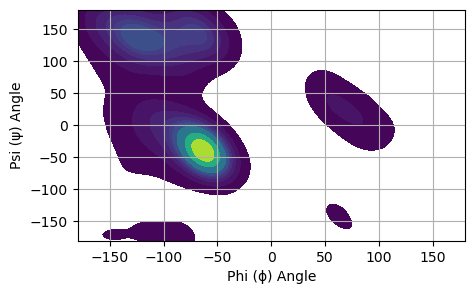

In [241]:
Ramachandran_plot()

In [861]:
def Ramachandran_plot_scatter(
    model = 'Nature',
    figsize = (5,3), 
    save_path = None
):
    
    plt.figure(figsize=figsize)

    kind, name, version = model_sele_dict[model]        
    phi_angles = [val / np.pi * 180 for val in feature_dict[kind][name][version]['phi']]
    psi_angles = [val / np.pi * 180 for val in feature_dict[kind][name][version]['psi']]
    
    # Convert angles to arrays for plotting
    phi = np.array(phi_angles)
    psi = np.array(psi_angles)

    # Set up the plot
    plt.figure(figsize=figsize)
    plt.scatter(x=phi, y=psi, alpha=0.1)

    # Set labels and axis limits
    plt.xlabel("Phi (ϕ) Angle")
    plt.ylabel("Psi (ψ) Angle")
    plt.xlim(-180, 180)
    plt.ylim(-180, 180)
    plt.grid(True)
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
        
    plt.show()

<Figure size 500x300 with 0 Axes>

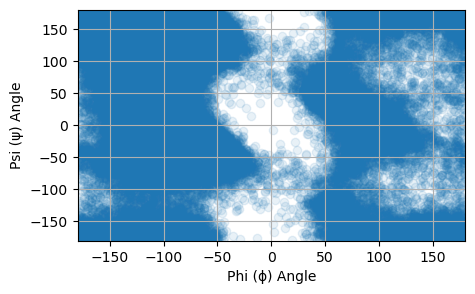

In [862]:
Ramachandran_plot_scatter()

In [857]:
len(feature_dict['LaDiff'][name]['stop']['phi'])

46156

In [657]:
len(consist_seq_dict['baseline']['Chroma']['stop'][1])

1810

In [658]:
len(consist_struc_dict['baseline']['Chroma']['stop'][1])

1810

In [659]:
len(foldability_dict['baseline']['Chroma']['stop'][0])

1810

In [660]:
len(designability_dict['baseline']['Chroma']['stop'][0])

185

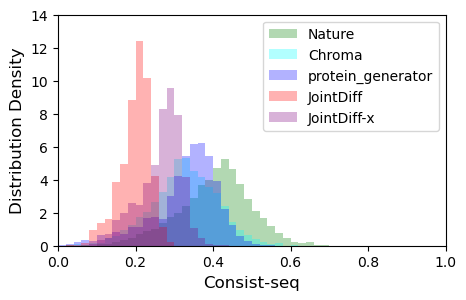

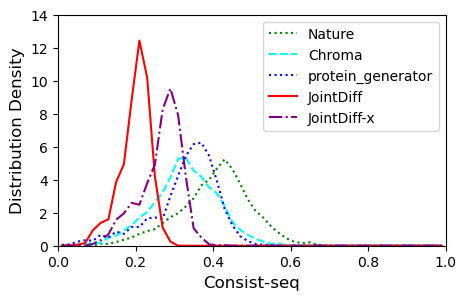

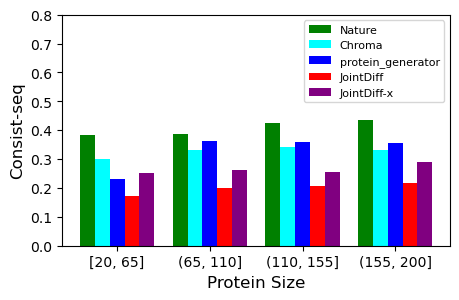

In [833]:
model_list = ['Nature', 'Chroma', 'protein_generator', 'JointDiff', 'JointDiff-x']
color_list = ['green', 'cyan', 'blue', 'red', 'purple']
linestyle = ['dotted', 'dashed', ':', 'solid', 'dashdot']

val_dict = consist_seq_dict
xlabel = 'Consist-seq'

density_plot(
    val_dict, 
    model_list = model_list, 
    color_list = color_list, 
    linestyle = linestyle, 
    alpha = 0.3,
    ylim=(0,14),
    x_label = xlabel,
    save_path = os.path.join(IMAGE_PATH, 'consistency-seq.png')
)

bin_length_plot(val_dict,  
    model_list = model_list,
    color_list = color_list, 
    length_range = ['[20, 65]', '(65, 110]', '(110, 155]', '(155, 200]'],
    figsize = (5,3), xlim=None, ylim = (0, 0.8),
    x_label='Protein Size', y_label = xlabel,
    save_path = os.path.join(IMAGE_PATH, 'consistency-seq_len.png')
)

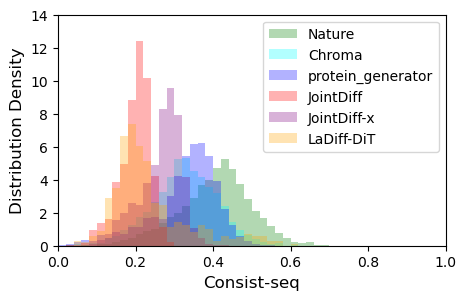

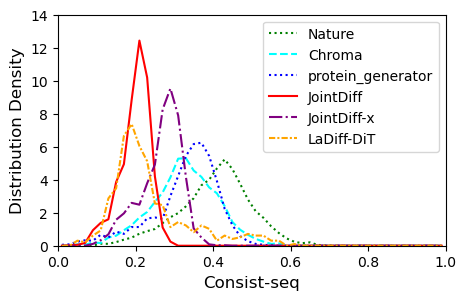

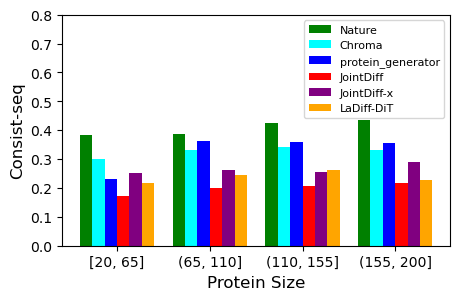

In [140]:
model_list = ['Nature', 'Chroma', 'protein_generator', 'JointDiff', 'JointDiff-x', 'LaDiff-DiT']
color_list = ['green', 'cyan', 'blue', 'red', 'purple', 'orange']
linestyle = ['dotted', 'dashed', ':', 'solid', 'dashdot', (0, (3, 1,1,1))]

val_dict = consist_seq_dict
xlabel = 'Consist-seq'

density_plot(
    val_dict, 
    model_list = model_list, 
    color_list = color_list, 
    linestyle = linestyle, 
    alpha = 0.3,
    ylim=(0,14),
    x_label = xlabel,
    save_path = os.path.join(IMAGE_PATH, 'consistency-seq.png')
)

bin_length_plot(val_dict,  
    model_list = model_list,
    color_list = color_list, 
    length_range = ['[20, 65]', '(65, 110]', '(110, 155]', '(155, 200]'],
    figsize = (5,3), xlim=None, ylim = (0, 0.8),
    x_label='Protein Size', y_label = xlabel,
    save_path = os.path.join(IMAGE_PATH, 'consistency-seq_len.png')
)

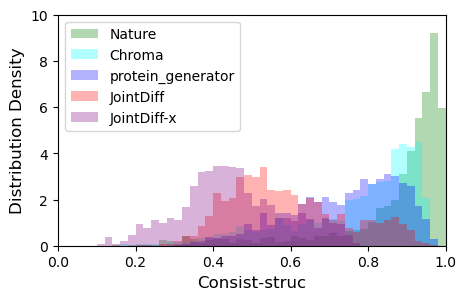

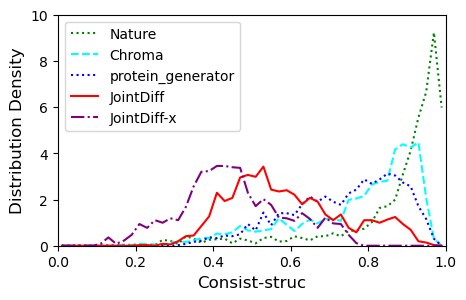

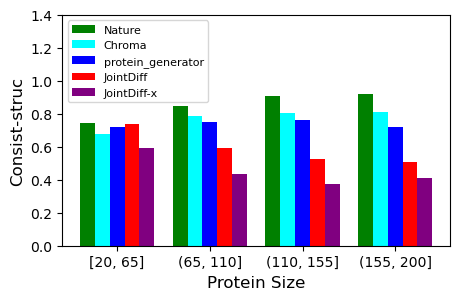

In [834]:
model_list = ['Nature', 'Chroma', 'protein_generator', 'JointDiff', 'JointDiff-x']
color_list = ['green', 'cyan', 'blue', 'red', 'purple']
linestyle = ['dotted', 'dashed', ':', 'solid', 'dashdot']

val_dict = consist_struc_dict
xlabel = 'Consist-struc'

density_plot(
    val_dict, 
    model_list = model_list, 
    color_list = color_list, 
    linestyle = linestyle, 
    alpha = 0.3,
    ylim=(0,10),
    x_label = xlabel,
    save_path = os.path.join(IMAGE_PATH, 'consistency-struc.png')
)

bin_length_plot(val_dict,  
    model_list = model_list,
    color_list = color_list, 
    length_range = ['[20, 65]', '(65, 110]', '(110, 155]', '(155, 200]'],
    figsize = (5,3), xlim=None, ylim = (0, 1.4),
    x_label='Protein Size', y_label = xlabel,
    save_path = os.path.join(IMAGE_PATH, 'consistency-struc_len.png')
)

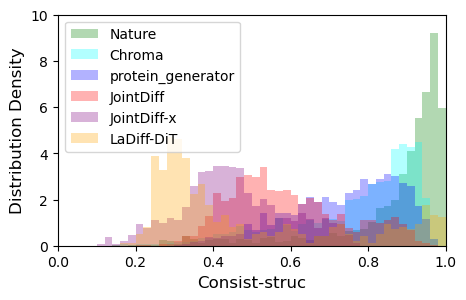

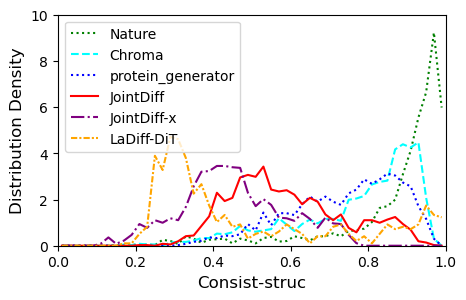

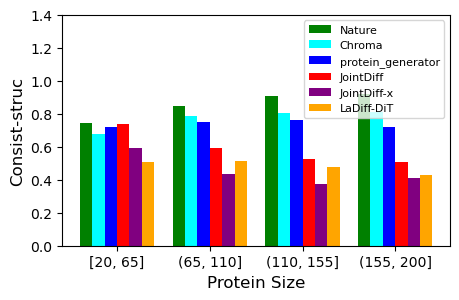

In [141]:
model_list = ['Nature', 'Chroma', 'protein_generator', 'JointDiff', 'JointDiff-x', 'LaDiff-DiT']
color_list = ['green', 'cyan', 'blue', 'red', 'purple', 'orange']
linestyle = ['dotted', 'dashed', ':', 'solid', 'dashdot', (0, (3, 1,1,1))]

val_dict = consist_struc_dict
xlabel = 'Consist-struc'

density_plot(
    val_dict, 
    model_list = model_list, 
    color_list = color_list, 
    linestyle = linestyle, 
    alpha = 0.3,
    ylim=(0,10),
    x_label = xlabel,
    save_path = os.path.join(IMAGE_PATH, 'consistency-struc.png')
)

bin_length_plot(val_dict,  
    model_list = model_list,
    color_list = color_list, 
    length_range = ['[20, 65]', '(65, 110]', '(110, 155]', '(155, 200]'],
    figsize = (5,3), xlim=None, ylim = (0, 1.4),
    x_label='Protein Size', y_label = xlabel,
    save_path = os.path.join(IMAGE_PATH, 'consistency-struc_len.png')
)

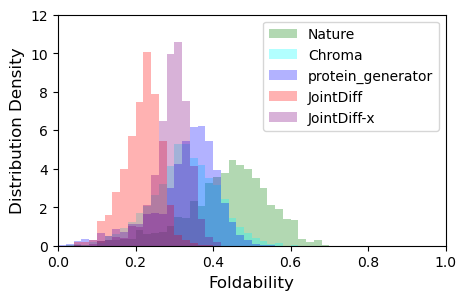

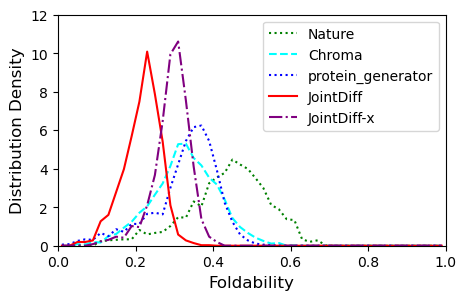

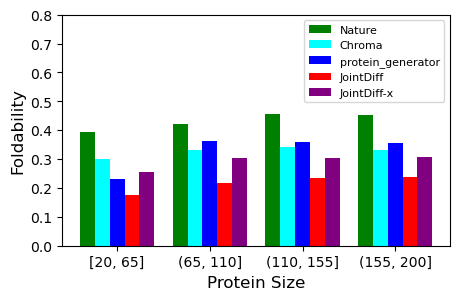

In [835]:
model_list = ['Nature', 'Chroma', 'protein_generator', 'JointDiff', 'JointDiff-x']
color_list = ['green', 'cyan', 'blue', 'red', 'purple']
linestyle = ['dotted', 'dashed', ':', 'solid', 'dashdot']
val_dict = foldability_dict
xlabel = 'Foldability'

density_plot(
    val_dict, 
    model_list = model_list, 
    color_list = color_list, 
    linestyle = linestyle, 
    alpha = 0.3,
    ylim=(0,12),
    x_label = xlabel,
    save_path = os.path.join(IMAGE_PATH, 'foldability.png')
)
bin_length_plot(val_dict,  
    model_list = model_list,
    color_list = color_list, 
    length_range = ['[20, 65]', '(65, 110]', '(110, 155]', '(155, 200]'],
    figsize = (5,3), xlim=None, ylim = (0, 0.8),
    x_label='Protein Size', y_label = xlabel,
    save_path = os.path.join(IMAGE_PATH, 'foldability_len.png')
)

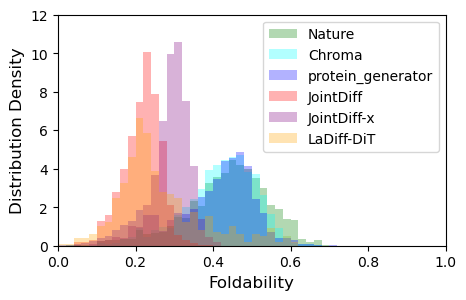

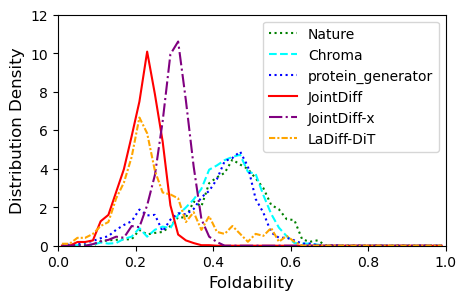

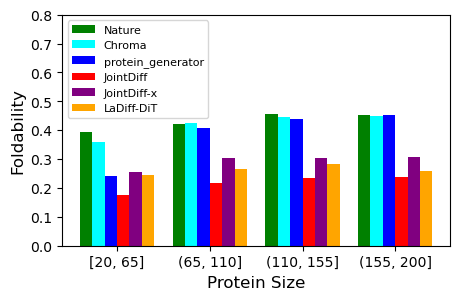

In [142]:
model_list = ['Nature', 'Chroma', 'protein_generator', 'JointDiff', 'JointDiff-x', 'LaDiff-DiT']
color_list = ['green', 'cyan', 'blue', 'red', 'purple', 'orange']
linestyle = ['dotted', 'dashed', ':', 'solid', 'dashdot', (0, (3, 1,1,1))]
val_dict = foldability_dict
xlabel = 'Foldability'

density_plot(
    val_dict, 
    model_list = model_list, 
    color_list = color_list, 
    linestyle = linestyle, 
    alpha = 0.3,
    ylim=(0,12),
    x_label = xlabel,
    save_path = os.path.join(IMAGE_PATH, 'foldability.png')
)
bin_length_plot(val_dict,  
    model_list = model_list,
    color_list = color_list, 
    length_range = ['[20, 65]', '(65, 110]', '(110, 155]', '(155, 200]'],
    figsize = (5,3), xlim=None, ylim = (0, 0.8),
    x_label='Protein Size', y_label = xlabel,
    save_path = os.path.join(IMAGE_PATH, 'foldability_len.png')
)

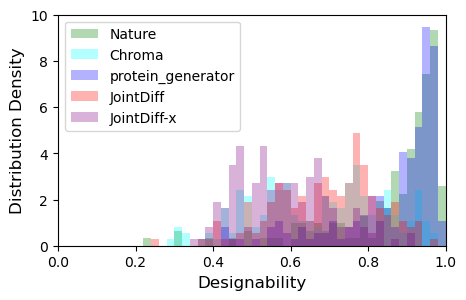

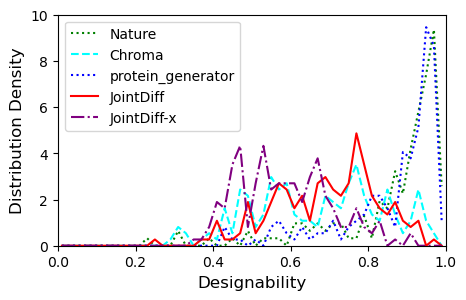

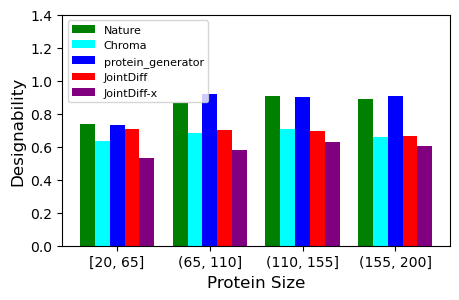

In [836]:
model_list = ['Nature', 'Chroma', 'protein_generator', 'JointDiff', 'JointDiff-x']
color_list = ['green', 'cyan', 'blue', 'red', 'purple']
linestyle = ['dotted', 'dashed', ':', 'solid', 'dashdot']
val_dict = designability_dict
xlabel = 'Designability'

density_plot(
    val_dict, 
    model_list = model_list, 
    color_list = color_list, 
    linestyle = linestyle, 
    alpha = 0.3,
    ylim=(0,10),
    x_label = xlabel,
    save_path = os.path.join(IMAGE_PATH, 'designabiliy.png')
)
bin_length_plot(val_dict,  
    model_list = model_list,
    color_list = color_list, 
    length_range = ['[20, 65]', '(65, 110]', '(110, 155]', '(155, 200]'],
    figsize = (5,3), xlim=None, ylim = (0, 1.4),
    x_label='Protein Size', y_label = xlabel,
    save_path = os.path.join(IMAGE_PATH, 'designability_len.png')
)

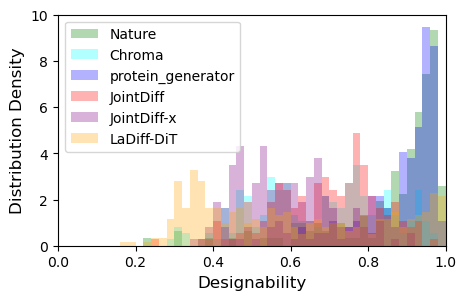

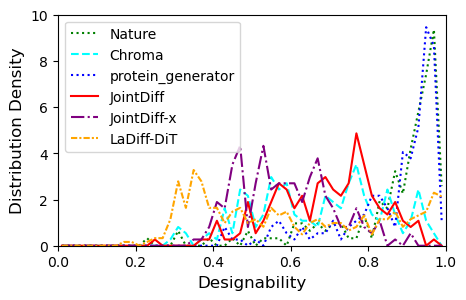

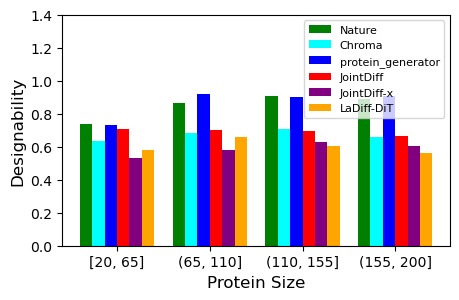

In [143]:
model_list = ['Nature', 'Chroma', 'protein_generator', 'JointDiff', 'JointDiff-x', 'LaDiff-DiT']
color_list = ['green', 'cyan', 'blue', 'red', 'purple', 'orange']
linestyle = ['dotted', 'dashed', ':', 'solid', 'dashdot', (0, (3, 1,1,1))]

val_dict = designability_dict
xlabel = 'Designability'

density_plot(
    val_dict, 
    model_list = model_list, 
    color_list = color_list, 
    linestyle = linestyle, 
    alpha = 0.3,
    ylim=(0,10),
    x_label = xlabel,
    save_path = os.path.join(IMAGE_PATH, 'designabiliy.png')
)
bin_length_plot(val_dict,  
    model_list = model_list,
    color_list = color_list, 
    length_range = ['[20, 65]', '(65, 110]', '(110, 155]', '(155, 200]'],
    figsize = (5,3), xlim=None, ylim = (0, 1.4),
    x_label='Protein Size', y_label = xlabel,
    save_path = os.path.join(IMAGE_PATH, 'designability_len.png')
)

/tmp/ipykernel_165727/3211571841.py:24: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, j + 1)


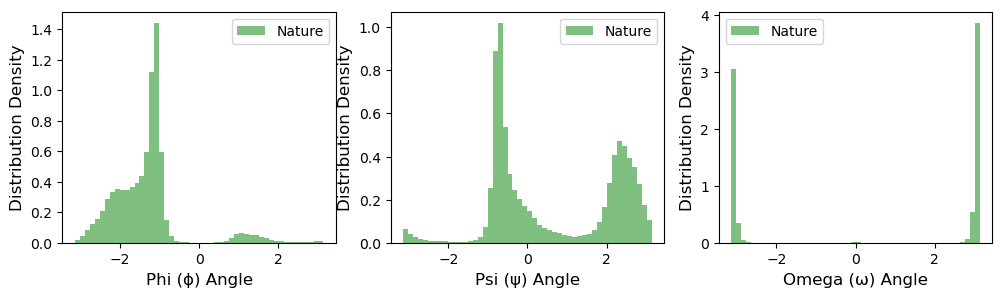

/tmp/ipykernel_165727/3211571841.py:45: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, j + 1)


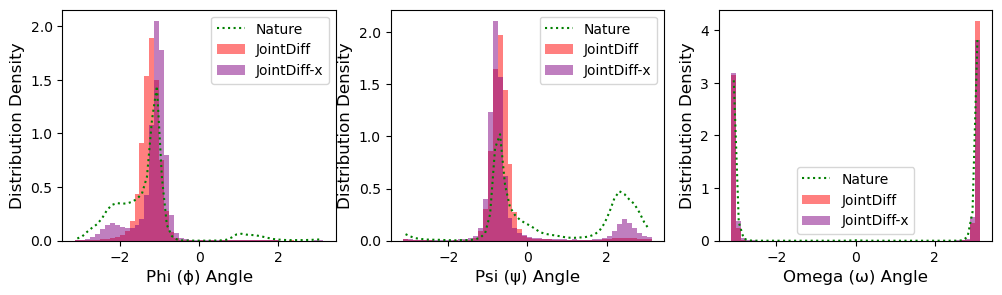

In [879]:
feature_plot(x_labels = ["Phi (ϕ) Angle", "Psi (ψ) Angle", "Omega (ω) Angle"], 
            save_path = os.path.join(IMAGE_PATH, 'feature_dist.png'))

<Figure size 500x300 with 0 Axes>

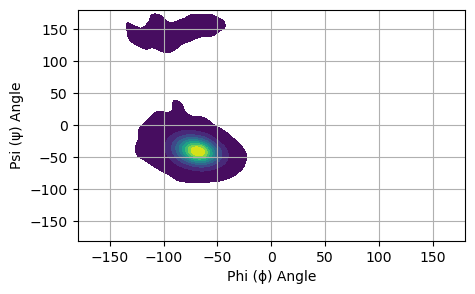

In [869]:
Ramachandran_plot(model = 'JointDiff', save_path = os.path.join(IMAGE_PATH, 'Ramachandran_JointDiff.png'))

<Figure size 500x300 with 0 Axes>

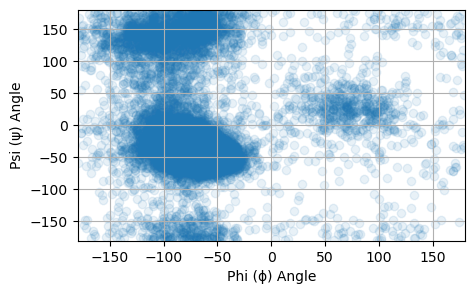

In [878]:
Ramachandran_plot_scatter(model = 'JointDiff', save_path = os.path.join(IMAGE_PATH, 'Ramachandran_JointDiff_scatter.png'))

<Figure size 500x300 with 0 Axes>

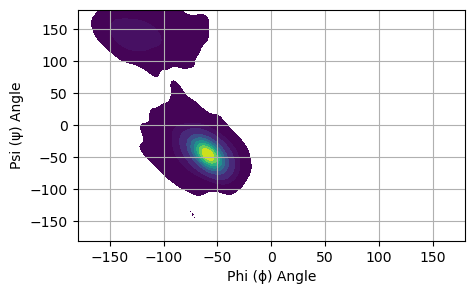

In [870]:
Ramachandran_plot(model = 'JointDiff-x', save_path = os.path.join(IMAGE_PATH, 'Ramachandran_JointDiff-x.png'))

<Figure size 500x300 with 0 Axes>

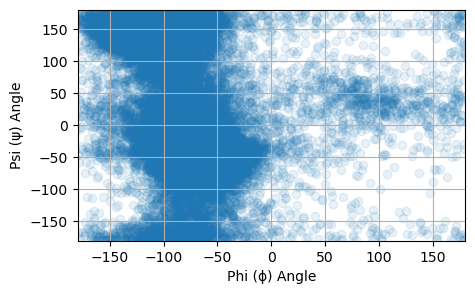

In [875]:
Ramachandran_plot_scatter(model = 'JointDiff-x', save_path = os.path.join(IMAGE_PATH, 'Ramachandran_JointDiff-x_scatter.png'))

<Figure size 500x300 with 0 Axes>

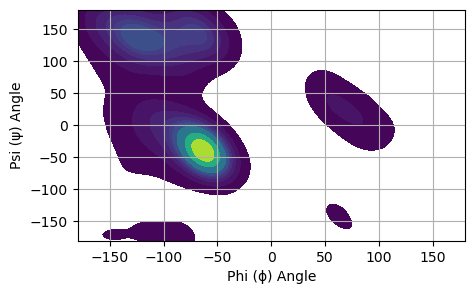

In [876]:
Ramachandran_plot(model = 'Nature', save_path = os.path.join(IMAGE_PATH, 'Ramachandran_Nature.png'))

<Figure size 500x300 with 0 Axes>

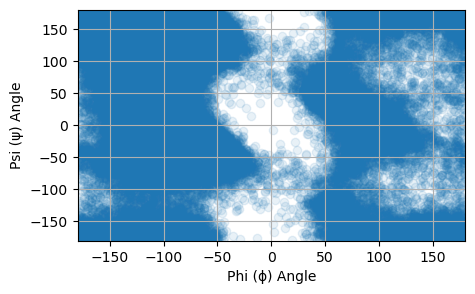

In [877]:
Ramachandran_plot_scatter(model = 'Nature', save_path = os.path.join(IMAGE_PATH, 'Ramachandran_Nature_scatter.png'))

In [5]:
model = torch.load('../../Logs/logs_originDiff/codesign_diffab_complete_gen_share-true_step100_lr1.e-4_wd0.0_posiscale50.0_2024_09_02__21_08_49/checkpoints/377000.pt')

In [2]:
import torch

In [6]:
model.keys()

dict_keys(['config', 'model', 'optimizer', 'scheduler', 'iteration', 'avg_val_loss'])

In [8]:
model['config']

{'model': {'type': 'diffab',
  'res_feat_dim': 128,
  'pair_feat_dim': 64,
  'diffusion': {'num_steps': 100,
   'eps_net_opt': {'num_layers': 6},
   'position_scale': [50.0]},
  'train_structure': True,
  'train_sequence': True,
  'gen_version': 'complete_gen',
  'encode_share': True,
  'proteinMPNN_path': None,
  'with_CEP_joint': False,
  'train_version': 'noise'},
 'train': {'loss_weights': {'rot': 1.0, 'pos': 1.0, 'seq': 1.0},
  'max_iters': 1000000,
  'val_freq': 1000,
  'batch_size': 16,
  'seed': 2022,
  'max_grad_norm': 100.0,
  'optimizer': {'type': 'adam',
   'lr': 0.0001,
   'weight_decay': 0.0,
   'beta1': 0.9,
   'beta2': 0.999},
  'scheduler': {'type': 'plateau',
   'factor': 0.8,
   'patience': 10,
   'min_lr': 5e-06}},
 'dataset': {'train': {'type': 'single_chain',
   'summary_path': '../../Data/Processed/CATH_forDiffAb/cath_summary_all.tsv',
   'chothia_dir': '../../Data/Origin/CATH/pdb_all/',
   'processed_dir': '../../Data/Processed/CATH_forDiffAb/',
   'split': 'tra

In [1]:
length_dict.keys()

NameError: name 'length_dict' is not defined